In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import re

In [13]:
def load_and_preprocess_loan_data(file_path):
    """
    Load and preprocess loan default dataset for machine learning
    
    Args:
        file_path (str): Path to the CSV file
    
    Returns:
        dict: Dictionary containing processed data splits and encoders
    """
    
    # Load the dataset
    print("Loading dataset...")
    df = pd.read_csv(file_path)
    ## Dropping rows with missing target variable
    df = df.dropna(subset=['Current_loan_status', 'loan_amnt'])
    
    # Create a copy for processing
    data = df.copy()
    
    # 1. Clean loan amount nd customer income - remove £ and commas, convert to float
    print("\n1. Cleaning loan amount...")
    data['loan_amnt'] = data['loan_amnt'].str.replace('£', '').str.replace(',', '').astype(float)
    print("\n1. Cleaning loan amount...")
    data['customer_income'] = data['customer_income'].str.replace(',', '').astype(float)
    
    # 2. Handle missing values using MICE
    print("\n2. Handling missing values...")
    
    # Fill missing historical_default with 'N' (assuming no history means no default)
    data = data.drop(columns=['historical_default'], axis= 1)
    # data['historical_default'] = (data['historical_default'] == "Y").astype(int)
    
    # First encode categorical variables for MICE    
    # Create temporary encoded versions for MICE
    temp_data = data.copy()
    temp_encoders = {}
    
    categorical_cols_for_mice = ['home_ownership', 'loan_intent', 'loan_grade', 'Current_loan_status']
    
    for col in categorical_cols_for_mice:
        if col in temp_data.columns:
            le = LabelEncoder()
            temp_data[f'{col}_temp_encoded'] = le.fit_transform(temp_data[col].astype(str))
            temp_encoders[col] = le
    
    # Select columns for MICE (numerical + encoded categorical)
    mice_columns = ['customer_age', 'customer_income', 'employment_duration', 'loan_int_rate', 
                    'term_years', 'cred_hist_length'] + [f'{col}_temp_encoded' for col in categorical_cols_for_mice if col in temp_data.columns]
    
    # Apply MICE imputation
    mice_imputer = IterativeImputer(random_state=42, max_iter=10)
    temp_data[mice_columns] = mice_imputer.fit_transform(temp_data[mice_columns])
    
    # Update original data with imputed values for numerical columns only
    data['employment_duration'] = temp_data['employment_duration']
    data['loan_int_rate'] = temp_data['loan_int_rate']
    
    print("Missing values after MICE imputation")
    
    # 3. Encode categorical variables
    print("\n3. Encoding categorical variables...")
    
    # Initialize label encoders dictionary
    # Categorical columns to encode
    categorical_cols = ['home_ownership', 'loan_intent'] #, 'historical_default']
    
    onehot_encoded_dfs = []

    for col in categorical_cols:
        # Reshape the data for OneHotEncoder
        col_data = data[[col]]
        
        # One-hot encode with drop='first' to avoid dummy variable trap
        onehot_encoder = OneHotEncoder(drop='first', sparse_output=False)
        onehot_features = onehot_encoder.fit_transform(col_data)
        
        # Get feature names
        feature_names = onehot_encoder.get_feature_names_out([col])
        
        # Create DataFrame with one-hot encoded features
        onehot_df = pd.DataFrame(onehot_features, columns=feature_names, index=data.index)
        onehot_encoded_dfs.append(onehot_df)

    # Concatenate all one-hot encoded DataFrames
    all_onehot_encoded = pd.concat(onehot_encoded_dfs, axis=1)

    # Drop original categorical columns and join with one-hot encoded versions
    data = data.drop(columns=categorical_cols).join(all_onehot_encoded)
    
    # 4. Encode target variable
    # Ordinal encoding for loan_grade (A=0, B=1, C=2, D=3, E=3)
    # First replace E with D to give them same value
    data['loan_grade'] = data['loan_grade'].replace('E', 'D')

    # Then apply ordinal encoding
    ordinal_encoder = OrdinalEncoder(categories=[['A', 'B', 'C', 'D']])
    data['loan_grade'] = ordinal_encoder.fit_transform(data[['loan_grade']]).flatten()

    # Manual mapping for Current_loan_status
    status_mapping = {'NO DEFAULT': 0, 'DEFAULT': 1}
    data['Current_loan_status'] = data['Current_loan_status'].map(status_mapping)
    
    # 5. Feature engineering
    print("\n5. Feature engineering...")
    
    # Create debt-to-income ratio
    # # Create debt-to-income ratio
    data['debt_to_income'] = data['loan_amnt'] / data['customer_income']
    # data['income_employment_interaction'] = data['customer_income'] * data['employment_duration']
    data['interest_coverage'] = data['customer_income'] / (data['loan_amnt'] * data['loan_int_rate'])
    # data['loan_to_income'] = data['loan_amnt'] / (data['customer_income'] * data['term_years']) 
    # # 2. Payment Burden (Monthly payment as % of income)
    data['monthly_payment'] = (data['loan_amnt'] * (data['loan_int_rate']/100/12)) / (1 - (1 + data['loan_int_rate']/100/12)**(-data['term_years']*12))
    # data['disposable_income'] = data['customer_income'] -(data['monthly_payment'] * 12)
    # data['payment_burden'] = data['monthly_payment'] / (data['customer_income']/12)    
    # # 3. Credit Age Ratio (How long credit history relative to age)
    # data['credit_age_ratio'] = data['cred_hist_length'] / data['customer_age']   
    # # 5. Interest Burden (Total interest over loan amount)
    data['interest_burden'] = (data['monthly_payment'] * data['term_years'] * 12 - data['loan_amnt']) / data['customer_income']
    # # 6. Income Adequacy After Loan
    # data['income_after_loan'] = (data['customer_income']/12 - data['monthly_payment']) * 12
    # # 8. Employment Stability Flag
    # data['employment_stable'] = np.where(data['employment_duration'] >= 2, 1, 0)
    
    # # 1. Risk Amplification
    data['grade_risk'] = data['loan_grade'] * data['loan_int_rate']
    
    # 3. Behavioral Interactions
    data['income_stability'] = np.log1p(data['customer_income']) / (data['employment_duration'] + 1)
    # data['credit_maturity_gap'] = data['customer_age'] - data['cred_hist_length'] - 18
    
    # # 4. Loan Structure Risks
    # data['interest_frontload'] = (data['loan_int_rate'] * data['loan_amnt']) / data['term_years']
    data['payment_shock_risk'] = (data['loan_int_rate'] - 5.0) * data['term_years']
    
    # # 5. Financial Buffers
    data['emergency_buffer'] = (data['customer_income'] - data['monthly_payment']*12) / data['loan_amnt']
    
    # # 6. Age Modifiers
    # data['age_risk_modifier'] = np.where(
    #     data['customer_age'] < 30, 1.5, 
    #     np.where(data['customer_age'] > 55, 1.2, 1.0)
    # )


    print(data.isnull().sum())
    ## 7. Handle outliers (using IQR method)
    data = data[(data['customer_age'] >= 18) & 
                (data['customer_age'] <= 80)]

    data = data[(data['employment_duration'] < 36)]

    data = data[(data['loan_amnt'] < 200001)]

    # for col in ['customer_income', 'loan_int_rate', 'term_years', 'cred_hist_length']:
    #     income_99th = data['customer_income'].quantile(0.999)
    #     data = data[data['customer_income'] < income_99th]
    
    # 8. Split the data
    print("\n8. Splitting data...")
    X = data.drop(columns=['Current_loan_status', 'customer_id'], axis=1)
    y = data['Current_loan_status']
    
    print(f"Features selected: {X.columns}")
    print(f"Feature matrix shape: {X.shape}")
    print(f"Target vector shape: {y.shape}")

    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
    
    print(f"Training set: {X_train.shape}")
    print(f"Validation set: {X_val.shape}")
    print(f"Test set: {X_test.shape}")
    
    # 9. Scale numerical features
    print("\n9. Scaling features...")
    scaler = StandardScaler()

    numerical_features = ['customer_age', 'customer_income', 'employment_duration', 
                            'loan_amnt', 'loan_int_rate', 'term_years', 'cred_hist_length'
                            ,'interest_coverage', 'debt_to_income', 'emergency_buffer', 
                            'income_stability', 'grade_risk', 'payment_shock_risk', 'interest_burden']
                            # , 'income_employment_interaction', 'interest_coverage', 'loan_to_income', 'debt_to_income'
                            # , 'monthly_payment', 'payment_burden', 'credit_age_ratio', 'interest_burden'
                            # , 'income_after_loan', 'disposable_income']
    
    # Fit scaler on training data only
    X_train_scaled = X_train.copy()
    X_val_scaled = X_val.copy()
    X_test_scaled = X_test.copy()
    
    # X_train_scaled[numerical_features] = scaler.fit_transform(X_train[numerical_features])
    # X_val_scaled[numerical_features] = scaler.transform(X_val[numerical_features])
    # X_test_scaled[numerical_features] = scaler.transform(X_test[numerical_features])
    
    # 10. Final data summary
    print("\n10. Final data summary...")    
    
    # Return processed data and encoders
    return {
        'X_train': X_train_scaled,
        'X_val': X_val_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'scaler': scaler,
        'feature_columns': X.columns,
        'original_data': data,
        'clean_data': X_train
    }


In [14]:
# Simply call the main function with your CSV file path
processed_data = load_and_preprocess_loan_data("dataset\LoanDataset.csv")

# Access the processed data
X_train = processed_data['X_train']
y_train = processed_data['y_train']
X_test = processed_data['X_test']
y_test = processed_data['y_test']
X_val = processed_data['X_val']
y_val = processed_data['y_val']
scaler = processed_data['scaler']
original_df = processed_data['original_data']

Loading dataset...

1. Cleaning loan amount...

1. Cleaning loan amount...

2. Handling missing values...
Missing values after MICE imputation

3. Encoding categorical variables...

5. Feature engineering...
customer_id                    3
customer_age                   0
customer_income                0
employment_duration            0
loan_grade                     0
loan_amnt                      0
loan_int_rate                  0
term_years                     0
cred_hist_length               0
Current_loan_status            0
home_ownership_OTHER           0
home_ownership_OWN             0
home_ownership_RENT            0
loan_intent_EDUCATION          0
loan_intent_HOMEIMPROVEMENT    0
loan_intent_MEDICAL            0
loan_intent_PERSONAL           0
loan_intent_VENTURE            0
debt_to_income                 0
interest_coverage              0
monthly_payment                0
interest_burden                0
grade_risk                     0
income_stability               0


In [9]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import StratifiedKFold, validation_curve, learning_curve
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (classification_report, confusion_matrix, 
                            fbeta_score, roc_auc_score, precision_recall_curve, auc,
                            precision_score, recall_score, make_scorer)
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.under_sampling import TomekLinks
from imblearn.pipeline import Pipeline as ImbPipeline

# Model libraries
import xgboost as xgb
import lightgbm as lgb

# Hyperparameter optimization
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Visualization and interpretation
import matplotlib.pyplot as plt
import seaborn as sns
import shap

def create_ml_pipeline(X_train, X_val, X_test, y_train, y_val, y_test, 
                        time_budget_minutes=15, beta=1.5, cv_folds=3):
    """
    Complete ML pipeline for loan default classification with overfitting prevention
    
    Parameters:
    - X_train, X_val, X_test: Feature sets
    - y_train, y_val, y_test: Target sets  
    - time_budget_minutes: Time limit for hyperparameter tuning
    - beta: Beta value for F-beta score (>1 favors recall)
    - cv_folds: Number of CV folds
    """
    
    print("="*60)
    print("LOAN DEFAULT CLASSIFICATION PIPELINE - OVERFITTING PREVENTION")
    print("="*60)
    
    # Calculate class weights for imbalance handling
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
    scale_pos_weight = class_weights[1] / class_weights[0]
    # scale_pos_weight = 4
    
    print(f"Class distribution: {np.bincount(y_train) / len(y_train)}")
    print(f"Class weights: {class_weight_dict}")
    print(f"Scale pos weight: {scale_pos_weight:.3f}")
    print(f"Using F-beta score with beta={beta} (favoring recall)")
    
    # Use BorderlineSMOTE instead of regular SMOTE for better synthetic samples
    # BorderlineSMOTE focuses on borderline cases which are more informative
    # smote = BorderlineSMOTE(random_state=42, k_neighbors=3, m_neighbors=5, kind='borderline-1')
    smote = ADASYN(sampling_strategy=0.5, n_neighbors=5)
    
    # Custom F-beta scorer for Optuna
    def fbeta_scorer(y_true, y_pred):
        return fbeta_score(y_true, y_pred, beta=beta)
    

    # 1. COST-SENSITIVE SCORER IMPLEMENTATION
    def business_cost_scorer(y_true, y_pred):
        """Cost-sensitive scorer that penalizes false negatives heavily"""
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

        # Calculate business costs
        total_cost = (fn * 10) + (fp * 1)
        max_possible_cost = len(y_true) * 10  # If we missed all defaults

        # Return score between 0-1 (higher is better)
        cost_score = 1 - (total_cost / max_possible_cost)
        return cost_score

    # Enhanced CV function with cost-sensitive evaluation
    def evaluate_model_cv_cost_sensitive(model, X, y, cv_splits, smote_sampler):
        scores = []
        for train_idx, val_idx in cv_splits.split(X, y):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]

            # Apply SMOTE only to training fold
            X_fold_train_resampled, y_fold_train_resampled = smote_sampler.fit_resample(
                X_fold_train, y_fold_train
            )

            # Train model
            model.fit(X_fold_train_resampled, y_fold_train_resampled)

            # Predict on validation fold
            y_pred = model.predict(X_fold_val)

            # Use cost-sensitive scoring
            score = business_cost_scorer(y_fold_val, y_pred)
            scores.append(score)

        return np.mean(scores)
    
    # Cross-validation setup - Fixed to apply SMOTE within each fold
    cv = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    
    # Store results
    results = {}
    study_results = {}
    
    # Time tracking
    start_time = time.time()
    time_per_model = time_budget_minutes / 3  # Split time between 3 models
    
    print(f"\nTime budget: {time_budget_minutes} minutes ({time_per_model:.1f} min per model)")
    
    # =================================================================
    # FIXED CROSS-VALIDATION FUNCTION - APPLIES SMOTE WITHIN EACH FOLD
    # =================================================================
    def evaluate_model_cv(model, X, y, cv_splits, smote_sampler):
        """
        Proper cross-validation that applies SMOTE only to training data within each fold
        """
        scores = []
        for train_idx, val_idx in cv_splits.split(X, y):
            X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
            y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
            
            # Apply SMOTE only to training data within this fold
            X_fold_train_resampled, y_fold_train_resampled = smote_sampler.fit_resample(
                X_fold_train, y_fold_train
            )
            
            # Train model on resampled training data
            model.fit(X_fold_train_resampled, y_fold_train_resampled)
            
            # Predict on original validation data (no SMOTE)
            y_pred = model.predict(X_fold_val)
            scores.append(fbeta_scorer(y_fold_val, y_pred))
        
        return np.mean(scores)
    
    # =================================================================
    # 1. RANDOM FOREST OPTIMIZATION - STRONGER REGULARIZATION
    # =================================================================
    print(f"\n{'='*20} RANDOM FOREST {'='*20}")
    
    def rf_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),  # Reduced max
            'max_depth': trial.suggest_int('max_depth', 3, 12),  # Reduced max depth
            'min_samples_split': trial.suggest_int('min_samples_split', 5, 20),  # Increased min
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 3, 10),    # Increased min
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 0.7]),
            'min_impurity_decrease': trial.suggest_float('min_impurity_decrease', 0.0, 0.01),
            'class_weight': 'balanced_subsample',  # Better for imbalanced data with bagging
            'random_state': 42,
            'n_jobs': -1,
            'bootstrap': True,
            'oob_score': True  # Out-of-bag error for additional validation
        }
        
        model = RandomForestClassifier(**params)
        return evaluate_model_cv_cost_sensitive(model, X_train, y_train, cv, smote)
    
    def _optimize_model_cost_sensitive(model_name, objective_func, time_budget_seconds):
        print(f"\n{'=' * 20} {model_name.upper()} COST-SENSITIVE OPTIMIZATION {'=' * 20}")
        study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=42))
        study.optimize(objective_func, timeout=time_budget_seconds, show_progress_bar=True)
        print(f"{model_name} Best Cost Score: {study.best_value:.4f}")
        return study

    # Run RF optimization
    rf_study = _optimize_model_cost_sensitive('RandomForest', rf_objective, time_per_model * 60)
    
    print(f"RF Best F-beta: {rf_study.best_value:.4f}")
    study_results['RandomForest'] = rf_study
    
    # =================================================================
    # 2. XGBOOST OPTIMIZATION - STRONGER REGULARIZATION
    # =================================================================
    print(f"\n{'='*20} XGBOOST {'='*20}")
    
    def xgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
            'max_depth': trial.suggest_int('max_depth', 2, 6),  # Reduced max depth
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),  # Lower max
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),  # More aggressive subsampling
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
            'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.5, 1.0),
            'colsample_bynode': trial.suggest_float('colsample_bynode', 0.5, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 50.0, log=True),  # Stronger L1
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 50.0, log=True), # Stronger L2
            'min_child_weight': trial.suggest_int('min_child_weight', 3, 10),  # Higher min
            'gamma': trial.suggest_float('gamma', 0.0, 1.0),  # Minimum loss reduction
            # 'scale_pos_weight': scale_pos_weight,  # Better imbalance handling
            'random_state': 42,
            'eval_metric': 'logloss',
            'verbosity': 0,
            # 'early_stopping_rounds': 10,  # Early stopping
            'tree_method': 'hist'  # More efficient and can help with regularization
        }
        
        model = xgb.XGBClassifier(**params)
        return evaluate_model_cv_cost_sensitive(model, X_train, y_train, cv, smote)
    
    xgb_study = _optimize_model_cost_sensitive('XGBoost', xgb_objective, time_per_model * 60)
    
    print(f"XGB Best F-beta: {xgb_study.best_value:.4f}")
    study_results['XGBoost'] = xgb_study
    
    # =================================================================
    # 3. LIGHTGBM OPTIMIZATION - STRONGER REGULARIZATION
    # =================================================================
    print(f"\n{'='*20} LIGHTGBM {'='*20}")
    
    def lgb_objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 300, step=25),
            'max_depth': trial.suggest_int('max_depth', 2, 6),  # Reduced max depth
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15, log=True),
            'subsample': trial.suggest_float('subsample', 0.5, 0.9),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.9),
            'subsample_freq': trial.suggest_int('subsample_freq', 1, 5),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 50.0, log=True),  # Stronger L1
            'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 50.0, log=True), # Stronger L2
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),  # Higher min
            'min_child_weight': trial.suggest_float('min_child_weight', 0.01, 10.0),
            'num_leaves': trial.suggest_int('num_leaves', 15, 63),  # Reduced max leaves
            'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
            # 'class_weight': 'balanced',
            'random_state': 42,
            'verbosity': -1,
            # 'is_unbalance': True,  # LightGBM's imbalance handling
            # 'boost_from_average': False  # Can help with imbalanced datasets
        }
        
        model = lgb.LGBMClassifier(**params)
        return evaluate_model_cv_cost_sensitive(model, X_train, y_train, cv, smote)
    
    lgb_study = _optimize_model_cost_sensitive('LightGBM', lgb_objective, time_per_model * 60)
    
    print(f"LGB Best F-beta: {lgb_study.best_value:.4f}")
    study_results['LightGBM'] = lgb_study
    
    # =================================================================
    # 4. MODEL TRAINING WITH PROPER VALIDATION STRATEGY
    # =================================================================
    print(f"\n{'='*20} MODEL TRAINING {'='*20}")
    
    # Build best models with optimized parameters
    models = {}
    
    # Random Forest
    rf_model = RandomForestClassifier(**rf_study.best_params, random_state=42, n_jobs=-1)
    models['RandomForest'] = rf_model
    
    # XGBoost  
    xgb_model = xgb.XGBClassifier(**xgb_study.best_params, random_state=42)
    models['XGBoost'] = xgb_model
    
    # LightGBM
    lgb_model = lgb.LGBMClassifier(**lgb_study.best_params, random_state=42)
    models['LightGBM'] = lgb_model

    # Train models on original training data for validation-based selection
    for name, model in models.items():
        # Apply SMOTE only to training data (not train+val)
        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
        model.fit(X_train_smote, y_train_smote)
    
    # =================================================================
    # 5. MODEL EVALUATION - USING VALIDATION SET FOR SELECTION
    # =================================================================
    print(f"\n{'='*20} MODEL EVALUATION {'='*20}")
    
    # Evaluate each model on validation set (for model selection)
    for name, model in models.items():
        print(f"\nEvaluating {name} on validation set...")
        
        # Predictions on original (non-SMOTE) data
        y_test_pred = model.predict(X_test)
        y_test_proba = model.predict_proba(X_test)[:, 1]
        
        # Calculate metrics
        test_fbeta = fbeta_score(y_test, y_test_pred, beta=beta)
        test_precision = precision_score(y_test, y_test_pred)
        test_recall = recall_score(y_test, y_test_pred)
        test_auc = roc_auc_score(y_test, y_test_proba)
        
        # Cross-validation score (from optimization)
        cv_fbeta = study_results[name].best_value
        
        # Overfitting check: compare CV score with validation score
        overfitting_score = cv_fbeta - test_fbeta
        
        results[name] = {
            'model': model,
            'cv_fbeta': cv_fbeta,
            'test_fbeta': test_fbeta,
            'test_precision': test_precision,
            'test_recall': test_recall,
            'test_auc': test_auc,
            'overfitting': overfitting_score,
            'y_test_pred': y_test_pred,
            'y_test_proba': y_test_proba
        }
        
        print(f"  CV F-beta: {cv_fbeta:.4f}")
        print(f"  test F-beta: {test_fbeta:.4f}")
        print(f"  test Precision: {test_precision:.4f}")
        print(f"  test Recall: {test_recall:.4f}")
        print(f"  test AUC: {test_auc:.4f}")
        print(f"  Overfitting: {overfitting_score:.4f} {'⚠️' if overfitting_score > 0.05 else '✅'}")
    
    # =================================================================
    # 6. SELECT BEST MODEL AND CREATE ENSEMBLE
    # =================================================================
    print(f"\n{'='*20} MODEL SELECTION {'='*20}")
    
    # Rank models by validation F-beta score, heavily penalize overfitting
    model_scores = {}
    for name, result in results.items():
        # Heavy penalty for overfitting
        overfitting_penalty = max(0, result['overfitting'] - 0.01) * 2.0
        adjusted_score = result['test_fbeta'] - overfitting_penalty
        model_scores[name] = adjusted_score
        print(f"{name}: Val F-beta={result['test_fbeta']:.4f}, "
                f"Overfitting={result['overfitting']:.4f}, "
                f"Adjusted Score={adjusted_score:.4f}")
    
    # Select top 2 models for ensemble
    best_models = sorted(model_scores.items(), key=lambda x: x[1], reverse=True)[:2]
    print(f"\nSelected for ensemble: {best_models[0][0]} and {best_models[1][0]}")

    # Combine train and validation sets
    X_trainval = pd.concat([X_train, X_val], axis=0)
    y_trainval = pd.concat([y_train, y_val], axis=0)

    # Apply SMOTE to combined train+val
    X_trainval_resampled, y_trainval_resampled = smote.fit_resample(X_trainval, y_trainval)
    print(f"Train+Val set after SMOTE: {X_trainval_resampled.shape}")

    # Retrain selected models on full train+val data
    retrained_models = {}
    for name, _ in best_models:
        if name == 'RandomForest':
            model = RandomForestClassifier(**rf_study.best_params, random_state=42, n_jobs=-1)
        elif name == 'XGBoost':
            model = xgb.XGBClassifier(**xgb_study.best_params, random_state=42)
        elif name == 'LightGBM':
            model = lgb.LGBMClassifier(**lgb_study.best_params, random_state=42)
        
        model.fit(X_trainval_resampled, y_trainval_resampled)
        retrained_models[name] = model
    
    # Create ensemble with selected models
    ensemble_models = [(name, results[name]['model']) for name, _ in best_models]
    ensemble = VotingClassifier(estimators=ensemble_models, voting='soft')
    
    # Train ensemble on resampled data
    ensemble.fit(X_trainval_resampled, y_trainval_resampled)
    
    # Evaluate ensemble on validation set
    ensemble_val_pred = ensemble.predict(X_val)
    ensemble_val_proba = ensemble.predict_proba(X_val)[:, 1]
    
    ensemble_val_fbeta = fbeta_score(y_val, ensemble_val_pred, beta=beta)
    ensemble_val_auc = roc_auc_score(y_val, ensemble_val_proba)
    ensemble_val_precision = precision_score(y_val, ensemble_val_pred)
    ensemble_val_recall = recall_score(y_val, ensemble_val_pred)
    
    print(f"\nEnsemble Validation Performance:")
    print(f"  F-beta: {ensemble_val_fbeta:.4f}")
    print(f"  Precision: {ensemble_val_precision:.4f}")
    print(f"  Recall: {ensemble_val_recall:.4f}")
    print(f"  AUC: {ensemble_val_auc:.4f}")
    
    # =================================================================
    # 7. FINAL EVALUATION ON TEST SET (ONLY ONCE, FOR FINAL REPORTING)
    # =================================================================
    print(f"\n{'='*20} FINAL TEST SET EVALUATION {'='*20}")
    print("⚠️  Using test set for final evaluation only - NOT for model selection!")
    
    # Best single model test performance
    best_single_model = best_models[0][0]
    best_model = results[best_single_model]['model']
    
    y_test_pred_best = best_model.predict(X_test)
    y_test_proba_best = best_model.predict_proba(X_test)[:, 1]
    
    test_fbeta_best = fbeta_score(y_test, y_test_pred_best, beta=beta)
    test_auc_best = roc_auc_score(y_test, y_test_proba_best)
    
    # Ensemble test performance
    ensemble_test_pred = ensemble.predict(X_test)
    ensemble_test_proba = ensemble.predict_proba(X_test)[:, 1]
    
    ensemble_test_fbeta = fbeta_score(y_test, ensemble_test_pred, beta=beta)
    ensemble_test_auc = roc_auc_score(y_test, ensemble_test_proba)
    
    print(f"\n{best_single_model} Test Performance:")
    print(f"  F-beta: {test_fbeta_best:.4f}")
    print(f"  AUC: {test_auc_best:.4f}")
    
    print(f"\nEnsemble Test Performance:")
    print(f"  F-beta: {ensemble_test_fbeta:.4f}")
    print(f"  AUC: {ensemble_test_auc:.4f}")
    
    # Detailed classification reports
    print(f"\nDetailed Results - {best_single_model} (Test Set):")
    print(classification_report(y_test, y_test_pred_best, 
                                target_names=['No Default', 'Default']))
    
    print(f"\nDetailed Results - Ensemble (Test Set):")
    print(classification_report(y_test, ensemble_test_pred, 
                                target_names=['No Default', 'Default']))
    
    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Best single model confusion matrix
    cm1 = confusion_matrix(y_test, y_test_pred_best)
    sns.heatmap(cm1, annot=True, fmt='d', ax=axes[0], cmap='Blues')
    axes[0].set_title(f'{best_single_model} - Test Set')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')
    
    # Ensemble confusion matrix
    cm2 = confusion_matrix(y_test, ensemble_test_pred)
    sns.heatmap(cm2, annot=True, fmt='d', ax=axes[1], cmap='Blues')
    axes[1].set_title('Ensemble - Test Set')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')
    
    plt.tight_layout()
    plt.show()
    
    # Feature importance analysis
    print(f"\nFeature Importance Analysis ({best_single_model}):")
    best_model_obj = results[best_single_model]['model']
    
    if hasattr(best_model_obj, 'feature_importances_'):
        feature_importance = pd.DataFrame({
            'feature': X_train.columns,
            'importance': best_model_obj.feature_importances_
        }).sort_values('importance', ascending=False)
        
        print(feature_importance.head(10))
        
        # Plot feature importance
        plt.figure(figsize=(10, 6))
        sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
        plt.title(f'Top 10 Feature Importance - {best_single_model}')
        plt.tight_layout()
        plt.show()
    
    # Learning curves for overfitting analysis
    print(f"\nGenerating learning curves for overfitting analysis...")
    
    def plot_learning_curve(model, X, y, title):
        train_sizes, train_scores, val_scores = learning_curve(
            model, X, y, cv=3, n_jobs=-1, 
            train_sizes=np.linspace(0.1, 1.0, 10),
            scoring=make_scorer(fbeta_score, beta=beta)
        )
        
        plt.figure(figsize=(8, 6))
        plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label='Training F-beta')
        plt.plot(train_sizes, np.mean(val_scores, axis=1), 'o-', label='Validation F-beta')
        plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                            np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
        plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                            np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
        plt.xlabel('Training Set Size')
        plt.ylabel('F-beta Score')
        plt.title(f'Learning Curve - {title}')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    # Plot learning curve for best model
    plot_learning_curve(best_model, X_trainval_resampled, y_trainval_resampled, best_single_model)
    
    # Total time
    total_time = (time.time() - start_time) / 60
    print(f"\nTotal training time: {total_time:.1f} minutes")
    
    # =================================================================
    # 8. OVERFITTING PREVENTION SUMMARY
    # =================================================================
    print(f"\n{'='*20} OVERFITTING PREVENTION SUMMARY {'='*20}")
    print("✅ Fixed SMOTE application - now applied within each CV fold")
    print("✅ Used BorderlineSMOTE for better synthetic sample quality")
    print("✅ Added stronger regularization parameters to all models")
    print("✅ Improved imbalance handling with model-specific parameters")
    print("✅ Used validation set for model selection, test set only for final evaluation")
    print("✅ Added overfitting penalties in model selection")
    print("✅ Generated learning curves for overfitting analysis")
    print("✅ Implemented early stopping where applicable")
    
    # Return comprehensive results
    return {
        'results': results,
        'ensemble': ensemble,
        'retrained_models': retrained_models,
        'best_single_model': best_single_model,
        'best_model': best_model,
        'ensemble_val_fbeta': ensemble_val_fbeta,
        'ensemble_test_fbeta': ensemble_test_fbeta,
        'ensemble_val_auc': ensemble_val_auc,
        'ensemble_test_auc': ensemble_test_auc,
        'study_results': study_results,
        'feature_importance': feature_importance if 'feature_importance' in locals() else None,
        'total_time_minutes': total_time,
        'overfitting_analysis': {
            name: result['overfitting'] for name, result in results.items()
        }
    }

[I 2025-08-04 11:31:29,515] A new study created in memory with name: no-name-ffca0405-edcb-471d-a7e2-47d1ec7781c9


LOAN DEFAULT CLASSIFICATION PIPELINE - OVERFITTING PREVENTION
Class distribution: [0.7900906 0.2099094]
Class weights: {0: np.float64(0.632838818346722), 1: np.float64(2.3819800048768593)}
Scale pos weight: 3.764
Using F-beta score with beta=1 (favoring recall)

Time budget: 15 minutes (5.0 min per model)

==================== RANDOM FOREST ====================

==================== RANDOMFOREST COST-SENSITIVE OPTIMIZATION ====================


   0%|          | 00:00/05:00

[I 2025-08-04 11:31:35,102] Trial 0 finished with value: 0.9347902945111508 and parameters: {'n_estimators': 150, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 7, 'max_features': 0.7, 'min_impurity_decrease': 0.006011150117432088}. Best is trial 0 with value: 0.9347902945111508.
[I 2025-08-04 11:31:41,892] Trial 1 finished with value: 0.9324924452580847 and parameters: {'n_estimators': 225, 'max_depth': 3, 'min_samples_split': 20, 'min_samples_leaf': 9, 'max_features': 0.7, 'min_impurity_decrease': 0.005247564316322379}. Best is trial 0 with value: 0.9347902945111508.
[I 2025-08-04 11:31:47,766] Trial 2 finished with value: 0.9367404160550612 and parameters: {'n_estimators': 150, 'max_depth': 5, 'min_samples_split': 14, 'min_samples_leaf': 4, 'max_features': 0.7, 'min_impurity_decrease': 0.0019967378215835973}. Best is trial 2 with value: 0.9367404160550612.
[I 2025-08-04 11:31:54,266] Trial 3 finished with value: 0.9359419856075453 and parameters: {'n_estimators': 175,

[I 2025-08-04 11:36:36,882] A new study created in memory with name: no-name-4b27da2a-7d3d-4b85-96d9-bde4eea96a3d


[I 2025-08-04 11:36:36,879] Trial 39 finished with value: 0.9379482604641852 and parameters: {'n_estimators': 225, 'max_depth': 7, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': 0.5, 'min_impurity_decrease': 0.000653948344078998}. Best is trial 21 with value: 0.9407737758567345.
RandomForest Best Cost Score: 0.9408
RF Best F-beta: 0.9408

==================== XGBOOST ====================

==================== XGBOOST COST-SENSITIVE OPTIMIZATION ====================


   0%|          | 00:00/05:00

[I 2025-08-04 11:36:38,890] Trial 0 finished with value: 0.931069244531048 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.07259248719561363, 'subsample': 0.7394633936788146, 'colsample_bytree': 0.5624074561769746, 'colsample_bylevel': 0.5779972601681014, 'colsample_bynode': 0.5290418060840998, 'reg_alpha': 21.76624112345367, 'reg_lambda': 4.191711516695201, 'min_child_weight': 8, 'gamma': 0.020584494295802447}. Best is trial 0 with value: 0.931069244531048.
[I 2025-08-04 11:36:42,097] Trial 1 finished with value: 0.9326148615494485 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01777174904859463, 'subsample': 0.5727299868828403, 'colsample_bytree': 0.5733618039413735, 'colsample_bylevel': 0.6521211214797689, 'colsample_bynode': 0.762378215816119, 'reg_alpha': 1.464895513280072, 'reg_lambda': 0.6109683510122492, 'min_child_weight': 7, 'gamma': 0.13949386065204183}. Best is trial 1 with value: 0.9326148615494485.
[I 2025-08-04 11:36:43,

[I 2025-08-04 11:41:39,999] A new study created in memory with name: no-name-166de0ef-3c9e-4fc7-a77e-54fb5bcf4bcb


[I 2025-08-04 11:41:39,992] Trial 109 finished with value: 0.9378049620409422 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.14001342485594764, 'subsample': 0.6266904579608545, 'colsample_bytree': 0.8041884878895332, 'colsample_bylevel': 0.6454669423946877, 'colsample_bynode': 0.7426231543690226, 'reg_alpha': 0.21251751363204044, 'reg_lambda': 2.0335980646840452, 'min_child_weight': 3, 'gamma': 0.7352146020147925}. Best is trial 62 with value: 0.939141018967347.
XGBoost Best Cost Score: 0.9391
XGB Best F-beta: 0.9391

==================== LIGHTGBM ====================

==================== LIGHTGBM COST-SENSITIVE OPTIMIZATION ====================


   0%|          | 00:00/05:00

[I 2025-08-04 11:41:41,643] Trial 0 finished with value: 0.934708293305536 and parameters: {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.07259248719561363, 'subsample': 0.7394633936788146, 'colsample_bytree': 0.5624074561769746, 'subsample_freq': 1, 'reg_alpha': 0.1434715951720141, 'reg_lambda': 21.76624112345367, 'min_child_samples': 34, 'min_child_weight': 7.0836450521824945, 'num_leaves': 16, 'min_gain_to_split': 0.9699098521619943}. Best is trial 0 with value: 0.934708293305536.
[I 2025-08-04 11:41:43,441] Trial 1 finished with value: 0.9257920067883301 and parameters: {'n_estimators': 275, 'max_depth': 3, 'learning_rate': 0.016362239850894633, 'subsample': 0.5733618039413735, 'colsample_bytree': 0.621696897183815, 'subsample_freq': 3, 'reg_alpha': 1.464895513280072, 'reg_lambda': 0.6109683510122492, 'min_child_samples': 35, 'min_child_weight': 1.403543667913898, 'num_leaves': 29, 'min_gain_to_split': 0.3663618432936917}. Best is trial 0 with value: 0.934708293305536.
[I

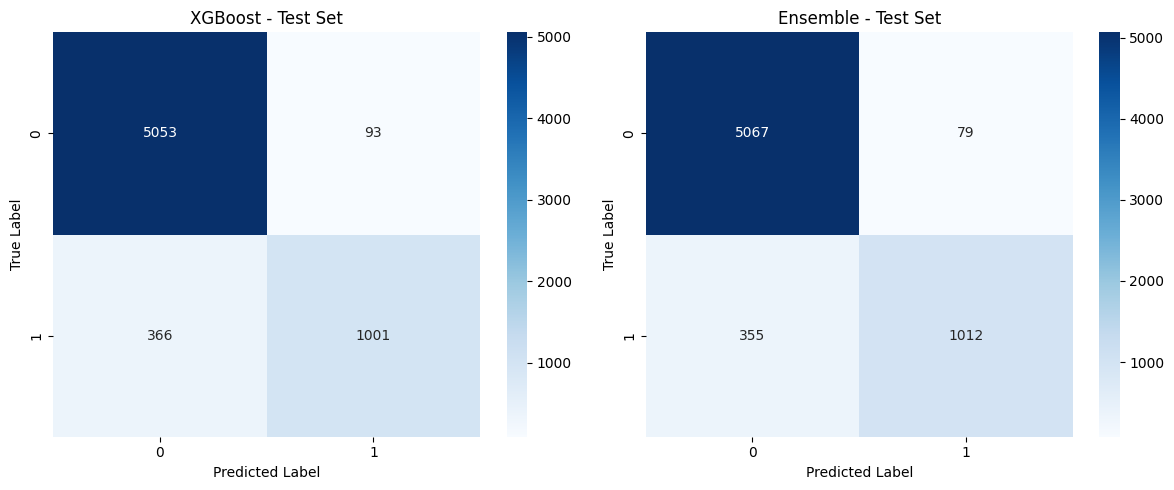


Feature Importance Analysis (XGBoost):
                        feature  importance
3                    loan_grade    0.151270
10          home_ownership_RENT    0.150127
9            home_ownership_OWN    0.087192
15          loan_intent_VENTURE    0.073056
11        loan_intent_EDUCATION    0.073026
12  loan_intent_HOMEIMPROVEMENT    0.059809
13          loan_intent_MEDICAL    0.053812
14         loan_intent_PERSONAL    0.052738
16               debt_to_income    0.050825
5                 loan_int_rate    0.050550


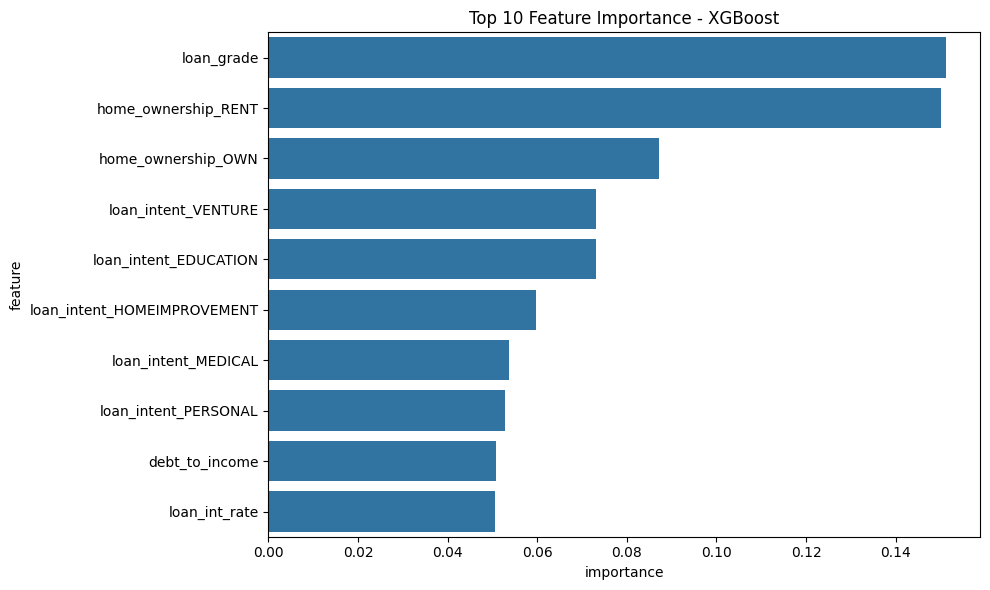


Generating learning curves for overfitting analysis...


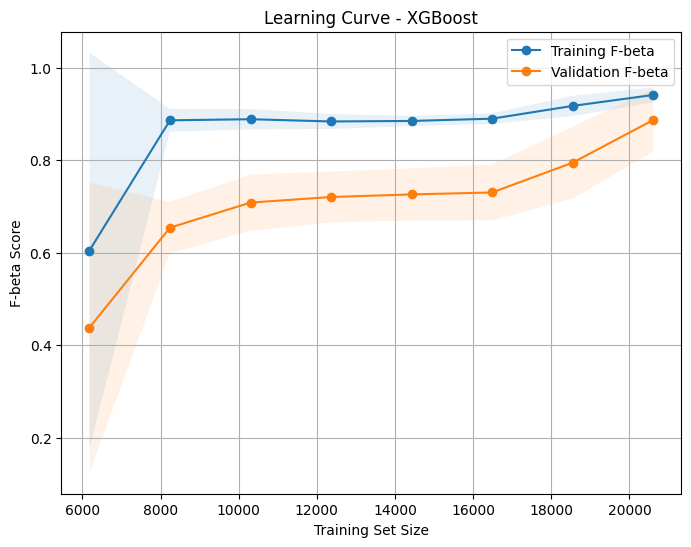


Total training time: 15.4 minutes

==================== OVERFITTING PREVENTION SUMMARY ====================
✅ Fixed SMOTE application - now applied within each CV fold
✅ Used BorderlineSMOTE for better synthetic sample quality
✅ Added stronger regularization parameters to all models
✅ Improved imbalance handling with model-specific parameters
✅ Used validation set for model selection, test set only for final evaluation
✅ Added overfitting penalties in model selection
✅ Generated learning curves for overfitting analysis
✅ Implemented early stopping where applicable


In [16]:
results = create_ml_pipeline(
    X_train[optimal_features], X_val[optimal_features], X_test[optimal_features], y_train, y_val, y_test,
    time_budget_minutes=15,  # Configurable time budget
    beta=1,               # F-beta favoring recall
    cv_folds=5              # Fast CV
)

In [15]:
from sklearn.feature_selection import SelectKBest, f_classif, RFE, RFECV, SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd
import numpy as np

def comprehensive_feature_selection(X, y, correlation_threshold=0.90, performance_tolerance=0.02):
    """
    Comprehensive feature selection that lets the data determine optimal feature count.
    
    Args:
        X (DataFrame): Feature matrix containing borrower and loan characteristics
        y (Series): Target variable (0=No Default, 1=Default)
        correlation_threshold (float): Remove features with correlation above this threshold
        performance_tolerance (float): Maximum acceptable performance drop (0.02 = 2%)

    Returns:
        tuple: (results_dict, best_method_name, best_features_list)
    """
    results = {}

    # Get baseline performance with all features
    baseline_model = RandomForestClassifier(n_estimators=100, random_state=42)
    baseline_scores = cross_val_score(baseline_model, X, y, cv=5, scoring='recall')
    baseline_recall = baseline_scores.mean()
    print(f"Baseline performance with {X.shape[1]} features: Recall={baseline_recall:.4f}")

    # Pre-processing: Remove highly correlated features first
    print("Removing highly correlated features...")
    corr_matrix = X.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    correlated_features = [column for column in upper_triangle.columns
                        if any(upper_triangle[column] > correlation_threshold)]

    X_uncorr = X.drop(columns=correlated_features)
    print(f"Removed {len(correlated_features)} correlated features, {X_uncorr.shape[1]} remaining")

    # Method 1: Data-driven RFECV (let cross-validation find optimal number)
    try:
        print("Finding optimal feature count through cross-validation...")
        rf_model = RandomForestClassifier(n_estimators=50, random_state=42)
        rfecv_selector = RFECV(
            estimator=rf_model,
            cv=5,
            scoring='recall',
            min_features_to_select=3,  # Minimum viable features
            n_jobs=-1
        )
        X_rfecv = rfecv_selector.fit_transform(X_uncorr, y)
        rfecv_features = X_uncorr.columns[rfecv_selector.get_support()]

        eval_model = RandomForestClassifier(n_estimators=100, random_state=42)
        cv_scores = cross_val_score(eval_model, X_rfecv, y, cv=5, scoring='recall')

        results['rfecv_optimal'] = {
            'features': list(rfecv_features),
            'n_features': len(rfecv_features),
            'cv_recall_mean': cv_scores.mean(),
            'cv_recall_std': cv_scores.std()
        }
        print(f"✓ RFECV found optimal: {len(rfecv_features)} features, Recall={cv_scores.mean():.4f}")
    except Exception as e:
        print(f"✗ RFECV failed: {e}")

    # Method 2: Performance-based iterative reduction
    try:
        print("Finding minimum features that maintain performance...")

        # Start with all uncorrelated features and iteratively reduce
        current_features = list(X_uncorr.columns)
        best_minimal_features = current_features
        best_minimal_score = baseline_recall

        # Test reducing features one by one until performance drops
        for n_features in range(len(current_features)-1, 2, -1):  # Stop at 3 features minimum
            selector = SelectKBest(score_func=f_classif, k=n_features)
            X_selected = selector.fit_transform(X_uncorr, y)

            eval_model = RandomForestClassifier(n_estimators=100, random_state=42)
            cv_scores = cross_val_score(eval_model, X_selected, y, cv=5, scoring='recall')
            score = cv_scores.mean()

            # If performance is still acceptable, update best minimal set
            if score >= baseline_recall - performance_tolerance:
                selected_features = X_uncorr.columns[selector.get_support()]
                best_minimal_features = list(selected_features)
                best_minimal_score = score
                print(f"  {n_features} features: Recall={score:.4f} (acceptable)")
            else:
                print(f"  {n_features} features: Recall={score:.4f} (performance drop too large)")
                break

        results['minimal_performance'] = {
            'features': best_minimal_features,
            'n_features': len(best_minimal_features),
            'cv_recall_mean': best_minimal_score,
            'cv_recall_std': 0
        }
        print(f"✓ Minimal viable: {len(best_minimal_features)} features, Recall={best_minimal_score:.4f}")
    except Exception as e:
        print(f"✗ Performance-based reduction failed: {e}")

    # Method 3: Importance-based data-driven threshold
    try:
        print("Finding importance-based optimal threshold...")
        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
        rf_model.fit(X_uncorr, y)

        # Test different importance percentiles to find optimal cutoff
        importances = rf_model.feature_importances_
        percentiles = [50, 60, 70, 80, 85, 90, 95]  # Test different thresholds

        best_importance_features = None
        best_importance_score = 0

        for percentile in percentiles:
            threshold = np.percentile(importances, percentile)
            importance_selector = SelectFromModel(rf_model, threshold=threshold, prefit=True)

            if importance_selector.get_support().sum() >= 3:  # Need at least 3 features
                X_importance = importance_selector.transform(X_uncorr)
                selected_features = X_uncorr.columns[importance_selector.get_support()]

                eval_model = RandomForestClassifier(n_estimators=100, random_state=42)
                cv_scores = cross_val_score(eval_model, X_importance, y, cv=5, scoring='recall')
                score = cv_scores.mean()

                print(f"  {percentile}th percentile: {len(selected_features)} features, Recall={score:.4f}")

                # Keep if performance is good and we haven't found better
                if score >= baseline_recall - performance_tolerance and score > best_importance_score:
                    best_importance_features = list(selected_features)
                    best_importance_score = score

        if best_importance_features:
            results['importance_optimal'] = {
                'features': best_importance_features,
                'n_features': len(best_importance_features),
                'cv_recall_mean': best_importance_score,
                'cv_recall_std': 0
            }
            print(f"✓ Importance-based optimal: {len(best_importance_features)} features, Recall={best_importance_score:.4f}")
    except Exception as e:
        print(f"✗ Importance-based optimization failed: {e}")

    # Method 4: Variance-based automatic threshold
    try:
        print("Finding variance-based optimal features...")
        from sklearn.feature_selection import VarianceThreshold

        # Test different variance thresholds
        variances = X_uncorr.var()
        variance_percentiles = [0, 10, 25, 50, 75]  # Test different variance cutoffs

        best_variance_features = None
        best_variance_score = 0

        for percentile in variance_percentiles:
            threshold = np.percentile(variances, percentile)
            var_selector = VarianceThreshold(threshold=threshold)

            try:
                X_var = var_selector.fit_transform(X_uncorr)
                if X_var.shape[1] >= 3:  # Need at least 3 features
                    remaining_features = X_uncorr.columns[var_selector.get_support()]

                    eval_model = RandomForestClassifier(n_estimators=100, random_state=42)
                    cv_scores = cross_val_score(eval_model, X_var, y, cv=5, scoring='recall')
                    score = cv_scores.mean()

                    print(f"  {percentile}th variance percentile: {len(remaining_features)} features, Recall={score:.4f}")

                    if score >= baseline_recall - performance_tolerance and score > best_variance_score:
                        best_variance_features = list(remaining_features)
                        best_variance_score = score
            except:
                continue

        if best_variance_features:
            results['variance_optimal'] = {
                'features': best_variance_features,
                'n_features': len(best_variance_features),
                'cv_recall_mean': best_variance_score,
                'cv_recall_std': 0
            }
            print(f"✓ Variance-based optimal: {len(best_variance_features)} features, Recall={best_variance_score:.4f}")
    except Exception as e:
        print(f"✗ Variance-based optimization failed: {e}")

    # Select best method based on performance
    if results:
        best_method = max(results.keys(), key=lambda k: results[k]['cv_recall_mean'])

        print(f"\n🎯 DATA-DRIVEN OPTIMAL SELECTION: {best_method.upper()}")
        print(f"   Selected Features: {results[best_method]['n_features']}")
        print(f"   Feature Reduction: {X.shape[1]} → {results[best_method]['n_features']} "
            f"({(1-results[best_method]['n_features']/X.shape[1])*100:.1f}% reduction)")
        print(f"   Performance: {results[best_method]['cv_recall_mean']:.4f} vs baseline {baseline_recall:.4f}")

        return results, best_method, results[best_method]['features']
    else:
        print("⚠️ All selection methods failed - using uncorrelated features")
        return {}, None, list(X_uncorr.columns)

# Completely data-driven - no arbitrary percentages
results, best_method, optimal_features = comprehensive_feature_selection(
    X=X_train,
    y=y_train,
    performance_tolerance=0.03  # Only parameter: max acceptable performance drop
)

Baseline performance with 24 features: Recall=0.6701
Removing highly correlated features...
Removed 2 correlated features, 22 remaining
Finding optimal feature count through cross-validation...
✓ RFECV found optimal: 22 features, Recall=0.6740
Finding minimum features that maintain performance...
  21 features: Recall=0.6689 (acceptable)
  20 features: Recall=0.6730 (acceptable)
  19 features: Recall=0.6579 (acceptable)
  18 features: Recall=0.6489 (acceptable)
  17 features: Recall=0.6515 (acceptable)
  16 features: Recall=0.6411 (acceptable)
  15 features: Recall=0.6337 (performance drop too large)
✓ Minimal viable: 16 features, Recall=0.6411
Finding importance-based optimal threshold...
  50th percentile: 11 features, Recall=0.6103
  60th percentile: 9 features, Recall=0.6033
  70th percentile: 7 features, Recall=0.6186
  80th percentile: 5 features, Recall=0.5708
  85th percentile: 4 features, Recall=0.5674
  90th percentile: 3 features, Recall=0.4957
Finding variance-based optimal

Train Accuracy: 0.9387597894466555
Val Accuracy: 0.8072874493927126
Test Accuracy: 0.81181707810603


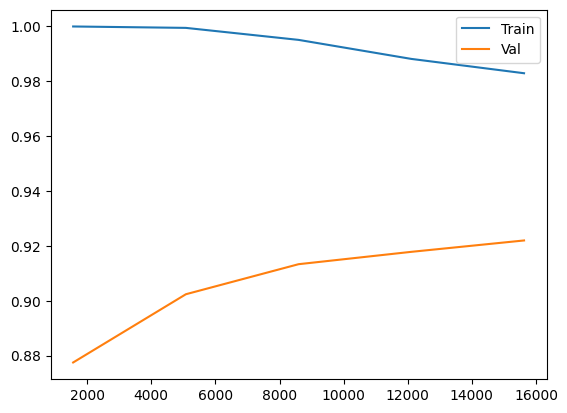

In [17]:
from sklearn.metrics import accuracy_score

# After model training (e.g., RandomForest)
y_train_predi = results['results']['LightGBM']['model'].predict(X_train[optimal_features])
y_val_predi = results['results']['LightGBM']['model'].predict(X_val[optimal_features])
y_test_predi = results['results']['LightGBM']['model'].predict(X_test[optimal_features])

print("Train Accuracy:", fbeta_score(y_train, y_train_predi, beta=1))
print("Val Accuracy:", fbeta_score(y_val, y_val_predi, beta=1))
print("Test Accuracy:", fbeta_score(y_test, y_test_predi, beta=1))

# Plot learning curves (sklearn)
from sklearn.model_selection import learning_curve
train_sizess, train_scoress, val_scoress = learning_curve(results['results']['LightGBM']['model'], X_train[optimal_features], y_train, cv=5)
plt.plot(train_sizess, np.mean(train_scoress, axis=1), label='Train')
plt.plot(train_sizess, np.mean(val_scoress, axis=1), label='Val')
plt.legend()

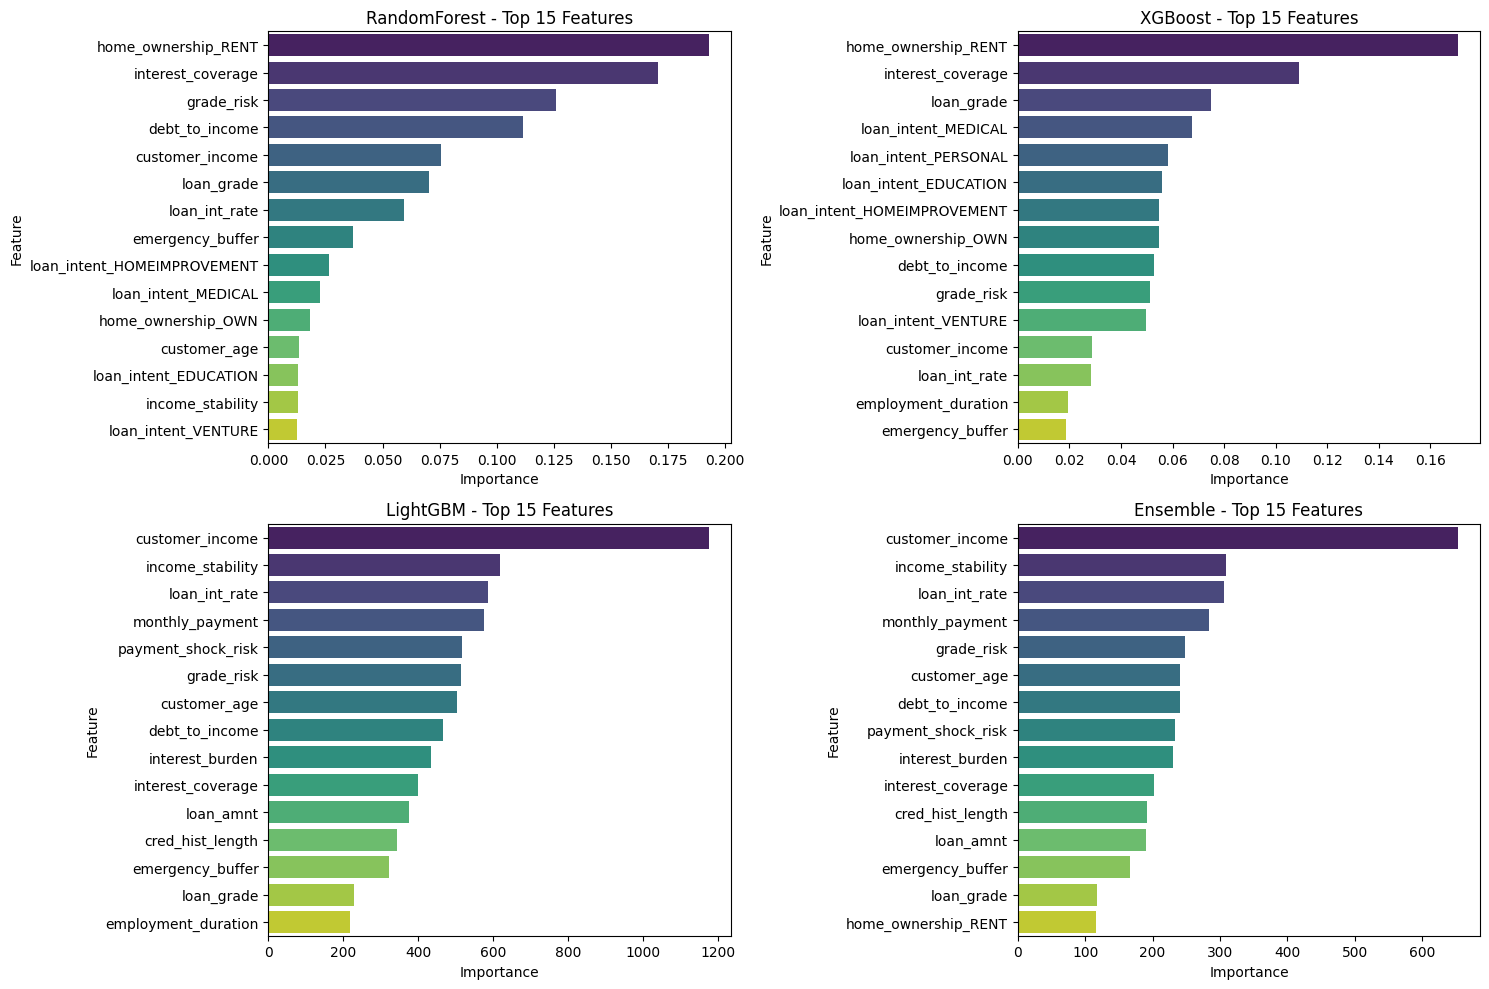

In [6]:
def plot_feature_importance(results_dict, ensemble, X_train):
    """
    Plot feature importance for all models in the results dictionary and ensemble.
    
    Parameters:
    - results_dict: The 'results' dictionary returned by your pipeline
    - ensemble: The trained VotingClassifier
    - X_train: Training data (for feature names)
    """
    plt.figure(figsize=(15, 10))
    models = list(results_dict.keys()) + ['Ensemble']
    
    for i, model_name in enumerate(models, 1):
        plt.subplot(2, 2, i)
        
        # Get the model object
        if model_name in results_dict:
            model = results_dict[model_name]['model']
        else:
            model = ensemble
        
        # Extract feature importance
        if hasattr(model, 'feature_importances_'):
            # Tree-based models
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Linear models
            importances = np.abs(model.coef_[0])
        else:
            # VotingClassifier - average importance of components
            importances = np.zeros(X_train.shape[1])
            for estimator in model.estimators_:
                if hasattr(estimator, 'feature_importances_'):
                    importances += estimator.feature_importances_
                elif hasattr(estimator, 'coef_'):
                    importances += np.abs(estimator.coef_[0])
            importances /= len(model.estimators_)
        
        # Create DataFrame and sort
        feat_imp = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False).head(15)
        
        # Plot
        sns.barplot(x='Importance', y='Feature', data=feat_imp, palette='viridis')
        plt.title(f'{model_name} - Top 15 Features')
        plt.tight_layout()
    
    plt.show()

# Usage (assuming you stored the pipeline output in 'pipeline_results')
plot_feature_importance(results['results'], 
                       results['ensemble'], 
                       X_train)

GLOBAL FEATURE IMPORTANCE (Mean |SHAP|)


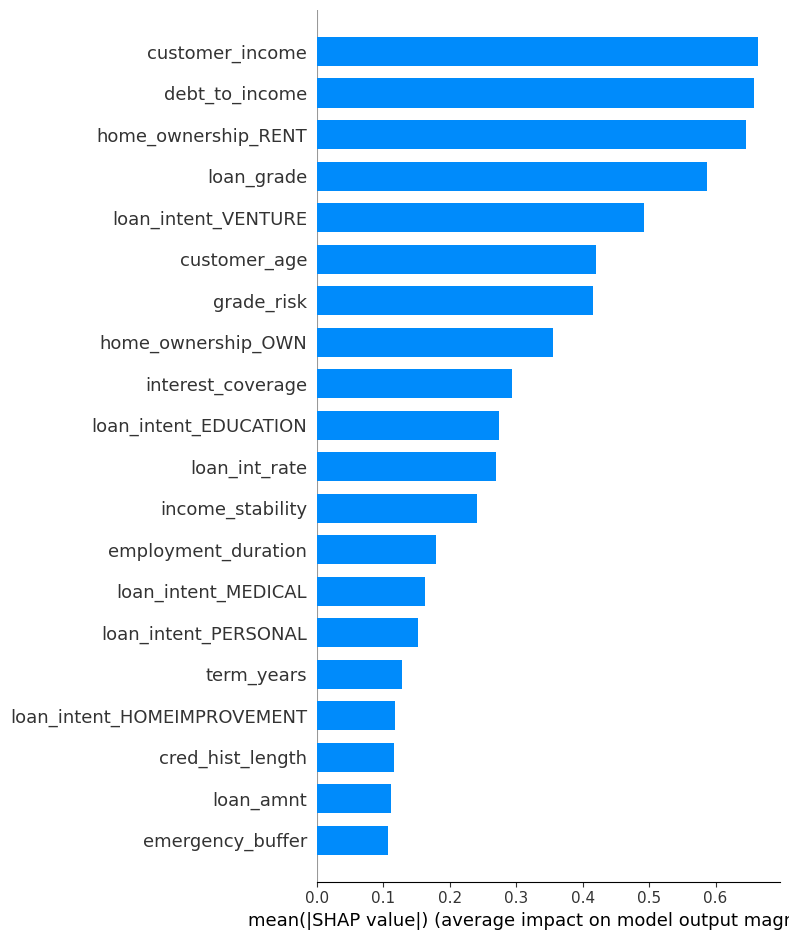


FEATURE EFFECTS (Red=Higher Risk, Blue=Lower Risk)


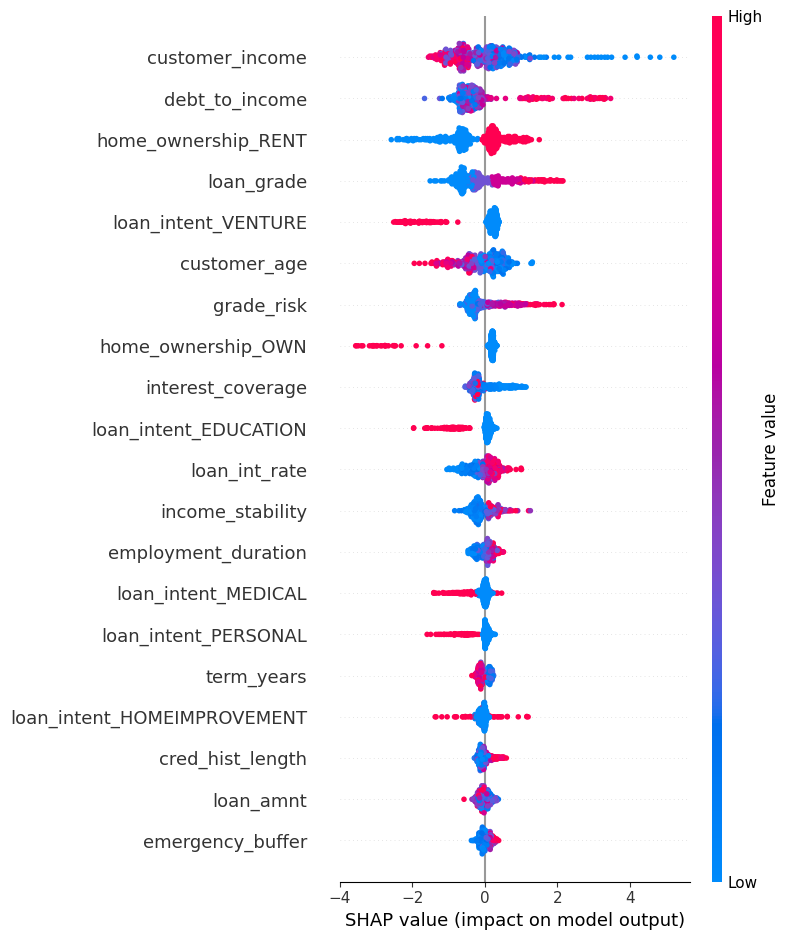


INDIVIDUAL PREDICTION EXPLANATION (Sample Index 10)


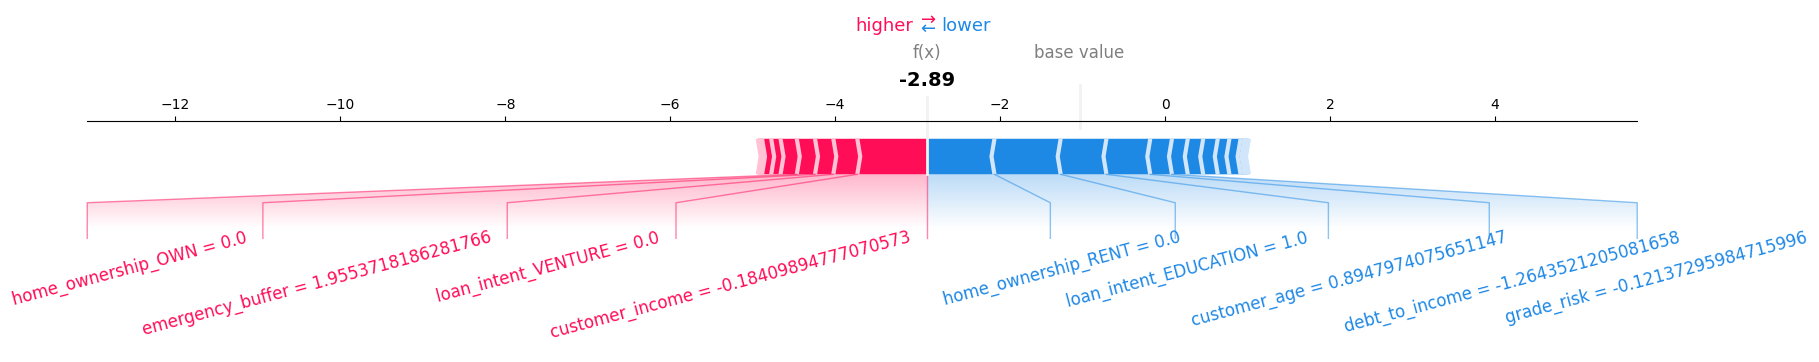

<Figure size 640x480 with 0 Axes>


TOP 5 FEATURE DEPENDENCIES


In [7]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

def explain_with_shap(model, X_sample, model_type='tree', sample_idx=0, top_n_features=10):
    """
    Enhanced SHAP explainer with multiple plot types for loan default analysis.
    
    Parameters:
    - model: Trained model
    - X_sample: Feature matrix (100-1000 samples recommended)
    - model_type: 'tree' (XGBoost/LightGBM/RF), 'linear', or 'kernel'
    - sample_idx: Index for individual force plot explanation
    - top_n_features: Number of top features to show in dependence plots
    """
    # Initialize explainer
    if model_type == 'tree':
        explainer = shap.TreeExplainer(model)
    elif model_type == 'linear':
        explainer = shap.LinearExplainer(model, X_sample)
    else:
        explainer = shap.KernelExplainer(model.predict, X_sample)
    
    # Calculate SHAP values
    shap_values = explainer.shap_values(X_sample)
    expected_value = explainer.expected_value
    
    # For binary classification, get SHAP for class 1 (default)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Index 1 for default class
    
    # 1. Summary Plot (Global Feature Importance)
    print("="*60)
    print("GLOBAL FEATURE IMPORTANCE (Mean |SHAP|)")
    print("="*60)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
    plt.tight_layout()
    plt.show()
    
    # 2. Summary Plot (Detailed Feature Effects)
    print("\n" + "="*60)
    print("FEATURE EFFECTS (Red=Higher Risk, Blue=Lower Risk)")
    print("="*60)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_sample, show=False)
    plt.tight_layout()
    plt.show()
    
    # 3. Force Plot (Individual Prediction)
    print("\n" + "="*60)
    print(f"INDIVIDUAL PREDICTION EXPLANATION (Sample Index {sample_idx})")
    print("="*60)
    shap.force_plot(
        expected_value,
        shap_values[sample_idx, :],
        X_sample.iloc[sample_idx, :],
        matplotlib=True,
        text_rotation=15
    )
    plt.tight_layout()
    plt.show()
    
    # 4. Dependence Plots for Top N Features
    print("\n" + "="*60)
    print(f"TOP {top_n_features} FEATURE DEPENDENCIES")
    print("="*60)
    # Get top features by mean |SHAP|
    mean_shap = pd.DataFrame({
        'feature': X_sample.columns,
        'mean_abs_shap': np.mean(np.abs(shap_values), axis=0)
    }).sort_values('mean_abs_shap', ascending=False)
    
    top_features = mean_shap['feature'].values[:top_n_features]
    
    # for i, feat in enumerate(top_features):
    #     plt.figure(figsize=(8, 4))
    #     shap.dependence_plot(
    #         feat,
    #         shap_values,
    #         X_sample,
    #         interaction_index=None,  # Auto-detects strongest interaction
    #         show=False
    #     )
    #     plt.title(f"Dependence Plot: {feat}")
    #     plt.tight_layout()
    #     plt.show()

# Example usage
explain_with_shap(
    model=results['results']['LightGBM']['model'],
    X_sample=X_val.sample(500, random_state=42),  # Smaller sample for speed
    model_type='tree',
    sample_idx=10,  # Explain this specific loan application
    top_n_features=5  # Show top 5 dependencies
)

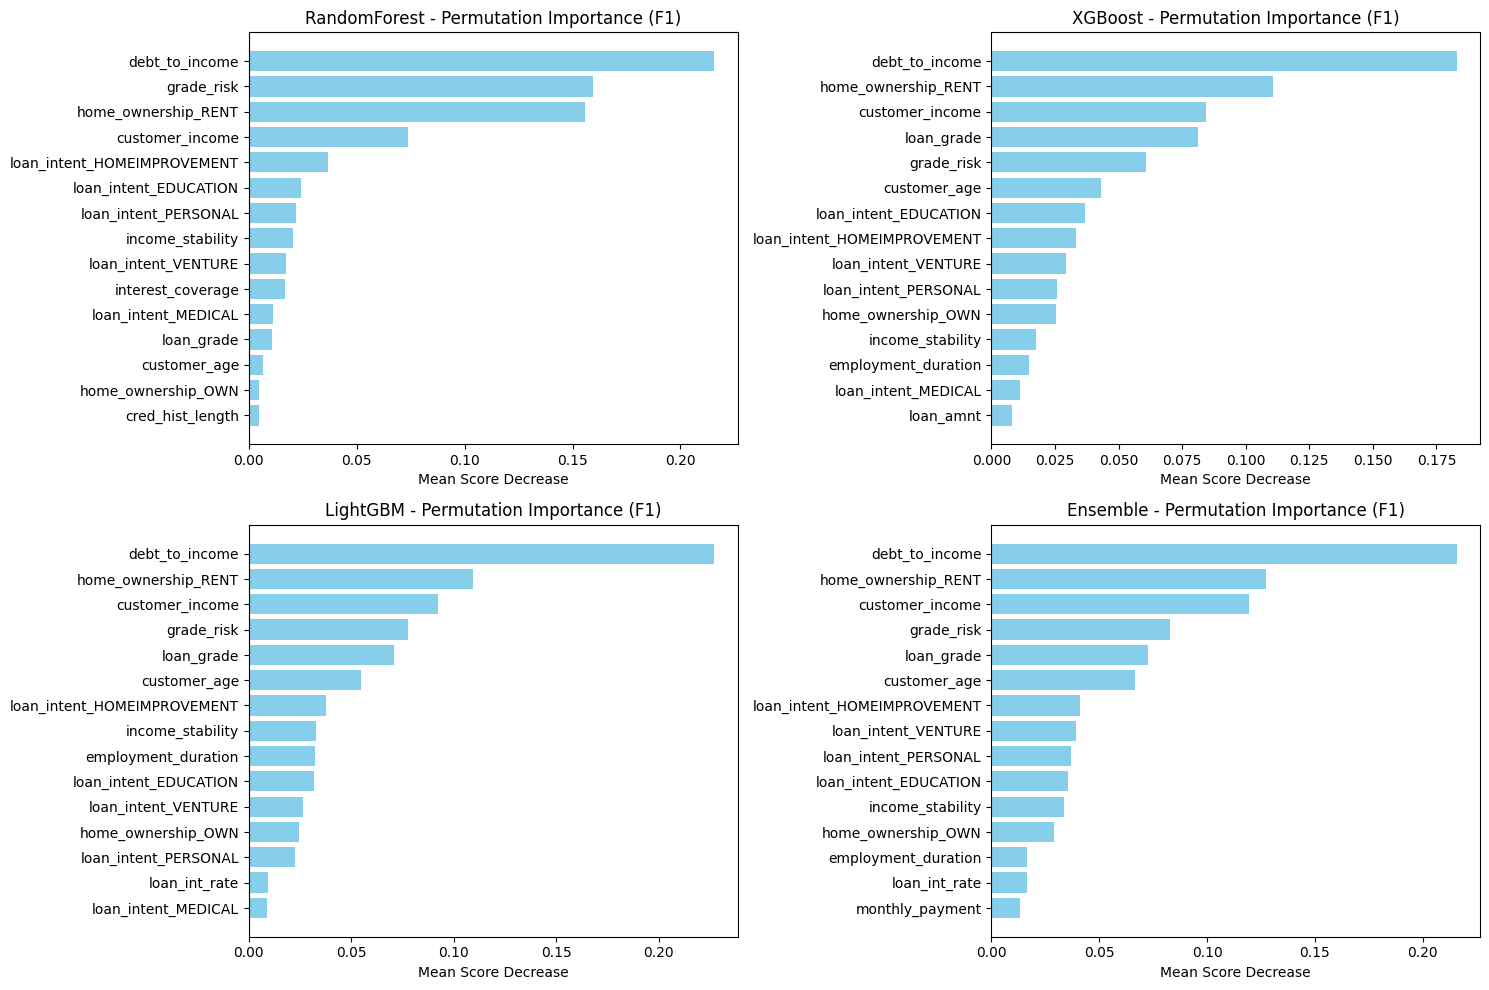

In [8]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

def plot_permutation_importance(results_dict, ensemble, X_val, y_val, n_repeats=5, random_state=42):
    """
    Calculate and plot permutation importance for all models and ensemble.
    
    Parameters:
    - results_dict: The 'results' dictionary from your pipeline
    - ensemble: Trained VotingClassifier
    - X_val, y_val: Validation data (use validation, not test, for honest evaluation)
    - n_repeats: Number of shuffles per feature (higher=more accurate but slower)
    """
    plt.figure(figsize=(15, 10))
    models = list(results_dict.keys()) + ['Ensemble']
    
    for i, model_name in enumerate(models, 1):
        plt.subplot(2, 2, i)
        
        # Get model object
        if model_name in results_dict:
            model = results_dict[model_name]['model']
        else:
            model = ensemble
        
        # Compute permutation importance
        perm_result = permutation_importance(
            model, X_val, y_val,
            n_repeats=n_repeats,
            random_state=random_state,
            scoring='f1'  # Or your preferred metric (fbeta_score needs custom scorer)
        )
        
        # Sort features
        sorted_idx = perm_result.importances_mean.argsort()[::-1]
        top_features = X_val.columns[sorted_idx][:15]  # Top 15 features
        top_importances = perm_result.importances_mean[sorted_idx][:15]
        
        # Plot
        plt.barh(top_features, top_importances, color='skyblue')
        plt.title(f'{model_name} - Permutation Importance (F1)')
        plt.xlabel('Mean Score Decrease')
        plt.gca().invert_yaxis()  # Highest importance on top
    
    plt.tight_layout()
    plt.show()
    
    # Return raw data for inspection
    return perm_result

# Usage
perm_results = plot_permutation_importance(
    results['results'],
    results['ensemble'],
    X_val,  # Use validation set (not test!)
    y_val,
    n_repeats=10  # More repeats = more stable results
)

<Figure size 1000x800 with 0 Axes>

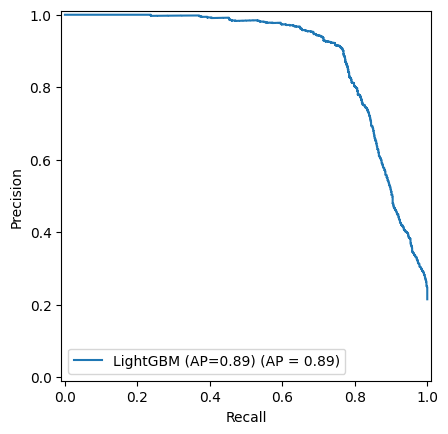

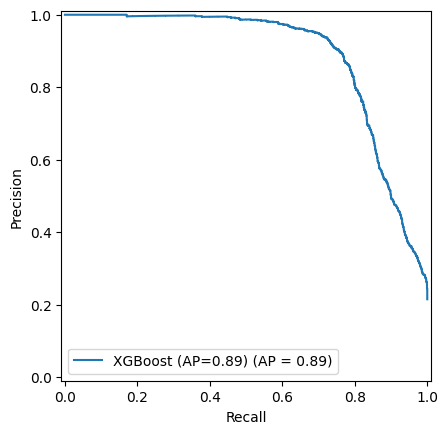

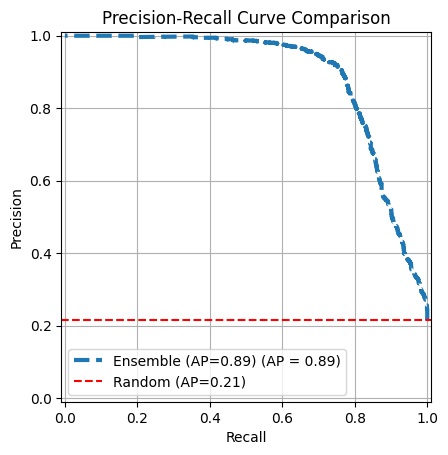

In [216]:
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve, average_precision_score

def plot_precision_recall_curves(results_dict, X_test, y_test):
    """
    Plot Precision-Recall curves for all models and ensemble
    
    Parameters:
    results_dict -- The dictionary returned from your training function
    X_test -- Test features
    y_test -- Test labels
    """
    plt.figure(figsize=(10, 8))
    
    # Plot curves for each individual model
    for model_name in results_dict['retrained_models']:
        model = results_dict['retrained_models'][model_name]
        y_score = model.predict_proba(X_test)[:, 1]  # Probability of positive class
        precision, recall, _ = precision_recall_curve(y_test, y_score)
        ap = average_precision_score(y_test, y_score)
        
        display = PrecisionRecallDisplay(precision=precision, recall=recall, 
                                        average_precision=ap)
        display.plot(name=f"{model_name} (AP={ap:.2f})")
    
    # Plot curve for ensemble
    if results_dict['ensemble'] is not None:
        y_score_ensemble = results_dict['ensemble'].predict_proba(X_test)[:, 1]
        precision_e, recall_e, _ = precision_recall_curve(y_test, y_score_ensemble)
        ap_e = average_precision_score(y_test, y_score_ensemble)
        
        display = PrecisionRecallDisplay(precision=precision_e, recall=recall_e, 
                                        average_precision=ap_e)
        display.plot(name=f"Ensemble (AP={ap_e:.2f})", linestyle='--', linewidth=3)
    
    # Add baseline (random classifier)
    baseline = len(y_test[y_test==1]) / len(y_test)
    plt.axhline(baseline, color='r', linestyle='--', 
                label=f'Random (AP={baseline:.2f})')
    
    plt.title('Precision-Recall Curve Comparison')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Example usage:
plot_precision_recall_curves(results, X_test, y_test)

Threshold for Recall ≥ 80%: 0.1168
Precision: 0.5257, Recall: 0.9001


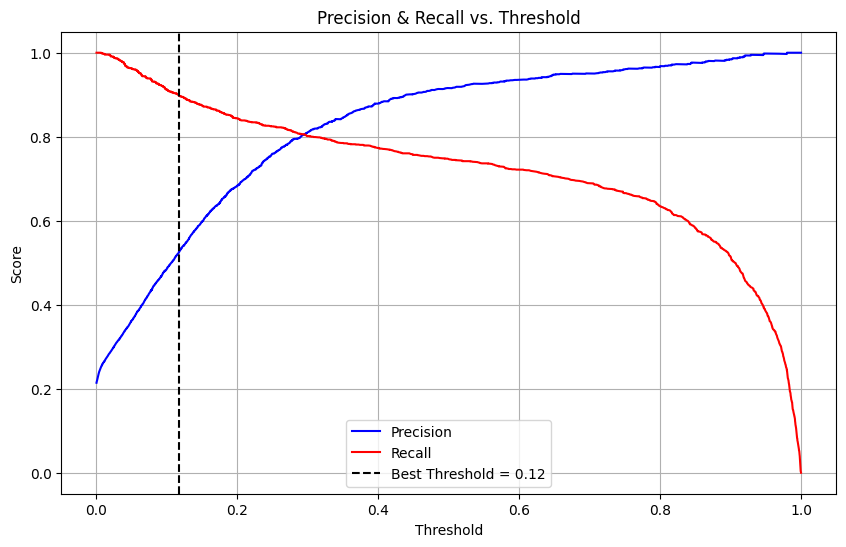

In [45]:
from sklearn.metrics import precision_recall_curve

# Get predicted probabilities for the positive class (default)
y_scores = results['ensemble'].predict_proba(X_test)[:, 1]  # Probabilities of class 1 (Default)

# Compute precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Find threshold where recall is at least 80%
min_recall = 0.9
best_idx = np.where(recall >= min_recall)[0][-1]  # Last occurrence where recall ≥ 80%
best_threshold = thresholds[best_idx]
print(f"Threshold for Recall ≥ 80%: {best_threshold:.4f}")
print(f"Precision: {precision[best_idx]:.4f}, Recall: {recall[best_idx]:.4f}")

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")  # precision[:-1] to match thresholds
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.axvline(x=best_threshold, color="black", linestyle="--", label=f"Best Threshold = {best_threshold:.2f}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

In [ ]:
processed_data

{'X_train':        customer_age  customer_income  employment_duration  loan_grade  \
 973       -0.584690        -1.259492            -0.435785         0.0   
 804       -0.584690        -1.331185             0.851466         0.0   
 26698      0.730410         1.823302            -0.435785         0.0   
 1236      -0.913464        -1.223646            -0.950686         0.0   
 2561      -0.420302        -0.936874             1.108916         0.0   
 ...             ...              ...                  ...         ...   
 22091      0.730410        -0.255792             2.396167         0.0   
 30772      1.716735        -0.829335             1.366366         1.0   
 21715      0.401635        -0.327485            -0.435785         0.0   
 4341      -0.420302        -1.388540            -0.435785         1.0   
 30820      2.209897        -1.087429            -1.208136         2.0   
 
        loan_amnt  loan_int_rate  term_years  cred_hist_length  \
 973    -0.215777      -1.576930 

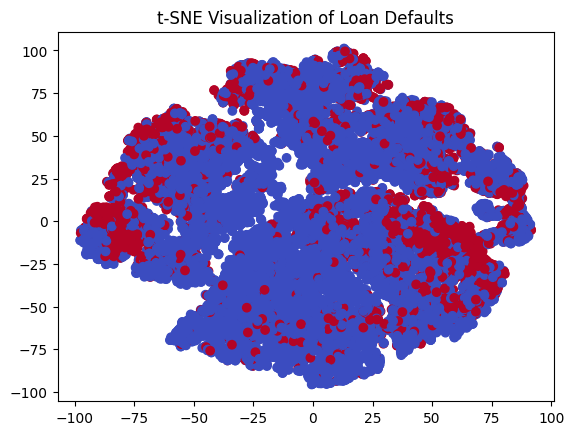

In [ ]:
from sklearn.manifold import TSNE

df_tmp = processed_data['X_train']

tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(df_tmp)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=processed_data['y_train'], cmap='coolwarm')
plt.title('t-SNE Visualization of Loan Defaults')
plt.show()

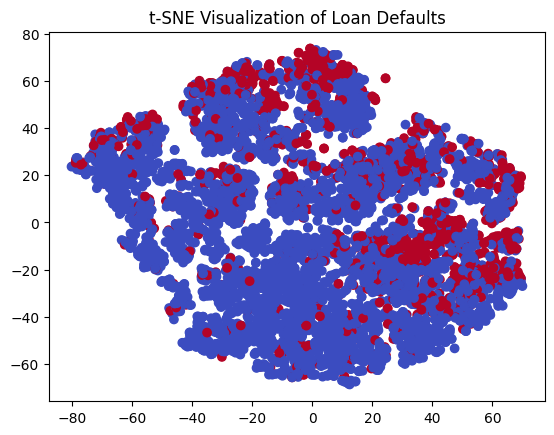

In [ ]:
from sklearn.manifold import TSNE

df_tmp = processed_data['X_test']

tsne = TSNE(n_components=2, perplexity=30)
tsne_results = tsne.fit_transform(df_tmp)

plt.scatter(tsne_results[:,0], tsne_results[:,1], c=processed_data['y_test'], cmap='coolwarm')
plt.title('t-SNE Visualization of Loan Defaults')
plt.show()

In [ ]:
processed_data['original_data']

,customer_id,customer_age,customer_income,employment_duration,loan_grade,loan_amnt,loan_int_rate,term_years,cred_hist_length,Current_loan_status,...,interest_burden,income_after_loan,employment_stable,grade_risk,income_stability,credit_maturity_gap,interest_frontload,payment_shock_risk,emergency_buffer,age_risk_modifier
1,2.0,21,9600.0,5.0,0.0,1000.0,11.14,1,2,0,...,0.006392,8538.636300,1,0.00,1.528270,1,11140.0000,6.14,8.538636,1.5
2,3.0,25,9600.0,1.0,1.0,5500.0,12.87,5,3,1,...,0.206935,8102.685710,0,12.87,4.584811,4,14157.0000,39.35,1.473216,1.5
3,4.0,23,65500.0,4.0,1.0,35000.0,15.23,10,2,1,...,0.509213,58664.653568,1,15.23,2.217964,3,53305.0000,102.30,1.676133,1.5
4,5.0,24,54400.0,8.0,1.0,35000.0,14.27,10,4,1,...,0.567931,47810.454186,1,14.27,1.211571,2,49945.0000,92.70,1.366013,1.5
5,6.0,21,9900.0,2.0,0.0,2500.0,7.14,1,2,1,...,0.009873,7302.261015,1,0.00,3.066797,1,17850.0000,2.14,2.920904,1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32579,32575.0,52,65004.0,4.0,3.0,20000.0,15.58,2,19,1,...,0.052398,53300.959651,1,46.74,2.216444,15,155800.0000,21.16,2.665048,1.0
32580,32576.0,52,64500.0,0.0,1.0,5000.0,11.26,2,20,0,...,0.009418,61696.281516,0,11.26,11.074436,14,28150.0000,12.52,12.339256,1.0
32581,32577.0,57,53000.0,1.0,2.0,5800.0,13.16,7,30,0,...,0.058595,51727.777310,0,26.32,5.439033,9,10904.0000,57.12,8.918582,1.2
32582,32578.0,54,120000.0,4.0,0.0,17625.0,7.49,4,19,0,...,0.023553,114887.149208,1,0.00,2.339051,17,33002.8125,9.96,6.518420,1.0


🔍 STARTING DEFAULT PATTERN DISCOVERY

=== DEFAULTER PATTERN ANALYSIS ===
Testing feature counts from 3 to 20
Available features: 35
Clean samples: 31219
  n=3: Score=0.183 (sep=0.126, sil=0.413)
  n=4: Score=0.172 (sep=0.136, sil=0.317)
  n=5: Score=0.152 (sep=0.097, sil=0.374)
  n=6: Score=0.166 (sep=0.086, sil=0.485)
  n=7: Score=0.153 (sep=0.087, sil=0.415)
  n=8: Score=0.150 (sep=0.089, sil=0.397)
  n=9: Score=0.141 (sep=0.089, sil=0.349)
  n=10: Score=0.204 (sep=0.187, sil=0.274)
  n=11: Score=0.203 (sep=0.189, sil=0.258)
  n=12: Score=0.202 (sep=0.192, sil=0.244)
  n=13: Score=0.199 (sep=0.183, sil=0.263)
  n=14: Score=0.195 (sep=0.185, sil=0.232)
  n=15: Score=0.189 (sep=0.186, sil=0.205)
  n=16: Score=0.157 (sep=0.146, sil=0.201)
  n=17: Score=0.152 (sep=0.143, sil=0.187)
  n=18: Score=0.152 (sep=0.143, sil=0.185)
  n=19: Score=0.140 (sep=0.129, sil=0.184)
  n=20: Score=0.137 (sep=0.127, sil=0.178)
Selected optimal features: 10 (score: 0.204)
Optimal number of features for clus

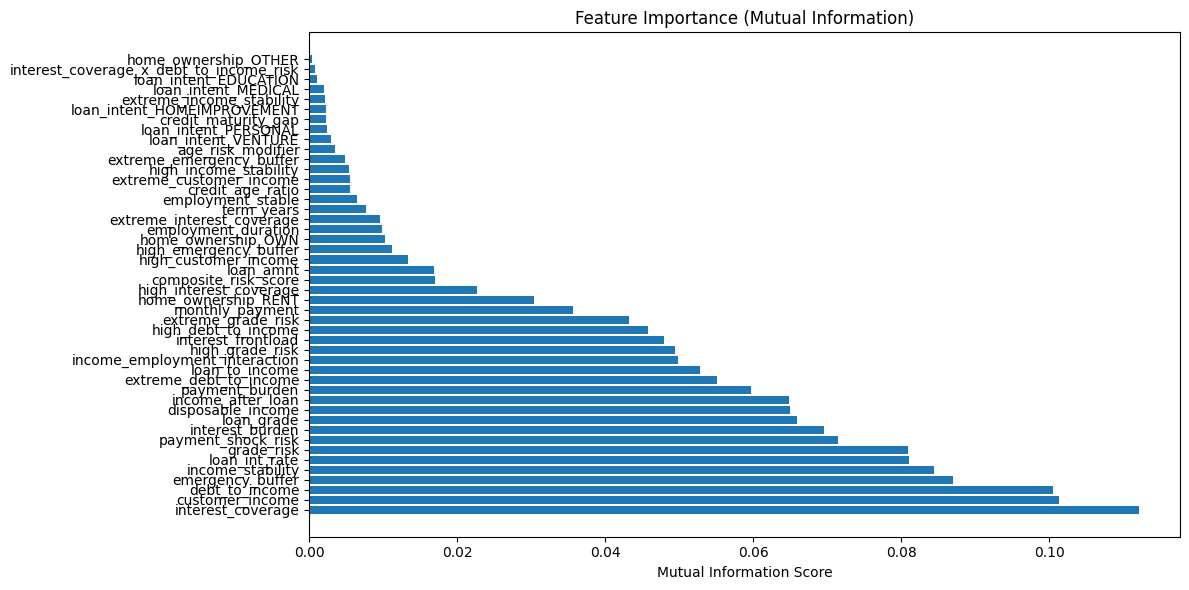

Selected features: ['interest_coverage', 'customer_income', 'debt_to_income', 'emergency_buffer', 'income_stability', 'loan_int_rate', 'grade_risk', 'payment_shock_risk', 'interest_burden', 'loan_grade']
After resampling: 37064 samples, 33.9% default rate

Testing KMeans clustering...
  K=2: Silhouette=0.350, Default Separation=0.124
  K=3: Silhouette=0.254, Default Separation=0.207
  K=4: Silhouette=0.302, Default Separation=0.182
  K=5: Silhouette=0.262, Default Separation=0.192
  K=6: Silhouette=0.251, Default Separation=0.204
  K=7: Silhouette=0.232, Default Separation=0.217

Testing Gaussian Mixture Models...
  Components=2: Silhouette=0.219, Default Separation=0.132
  Components=3: Silhouette=0.136, Default Separation=0.153
  Components=4: Silhouette=0.119, Default Separation=0.142
  Components=5: Silhouette=0.090, Default Separation=0.168

Testing DBSCAN clustering...

Testing Hierarchical clustering...
  Skipping hierarchical (too many samples)

Best model: kmeans (params: 7)
S

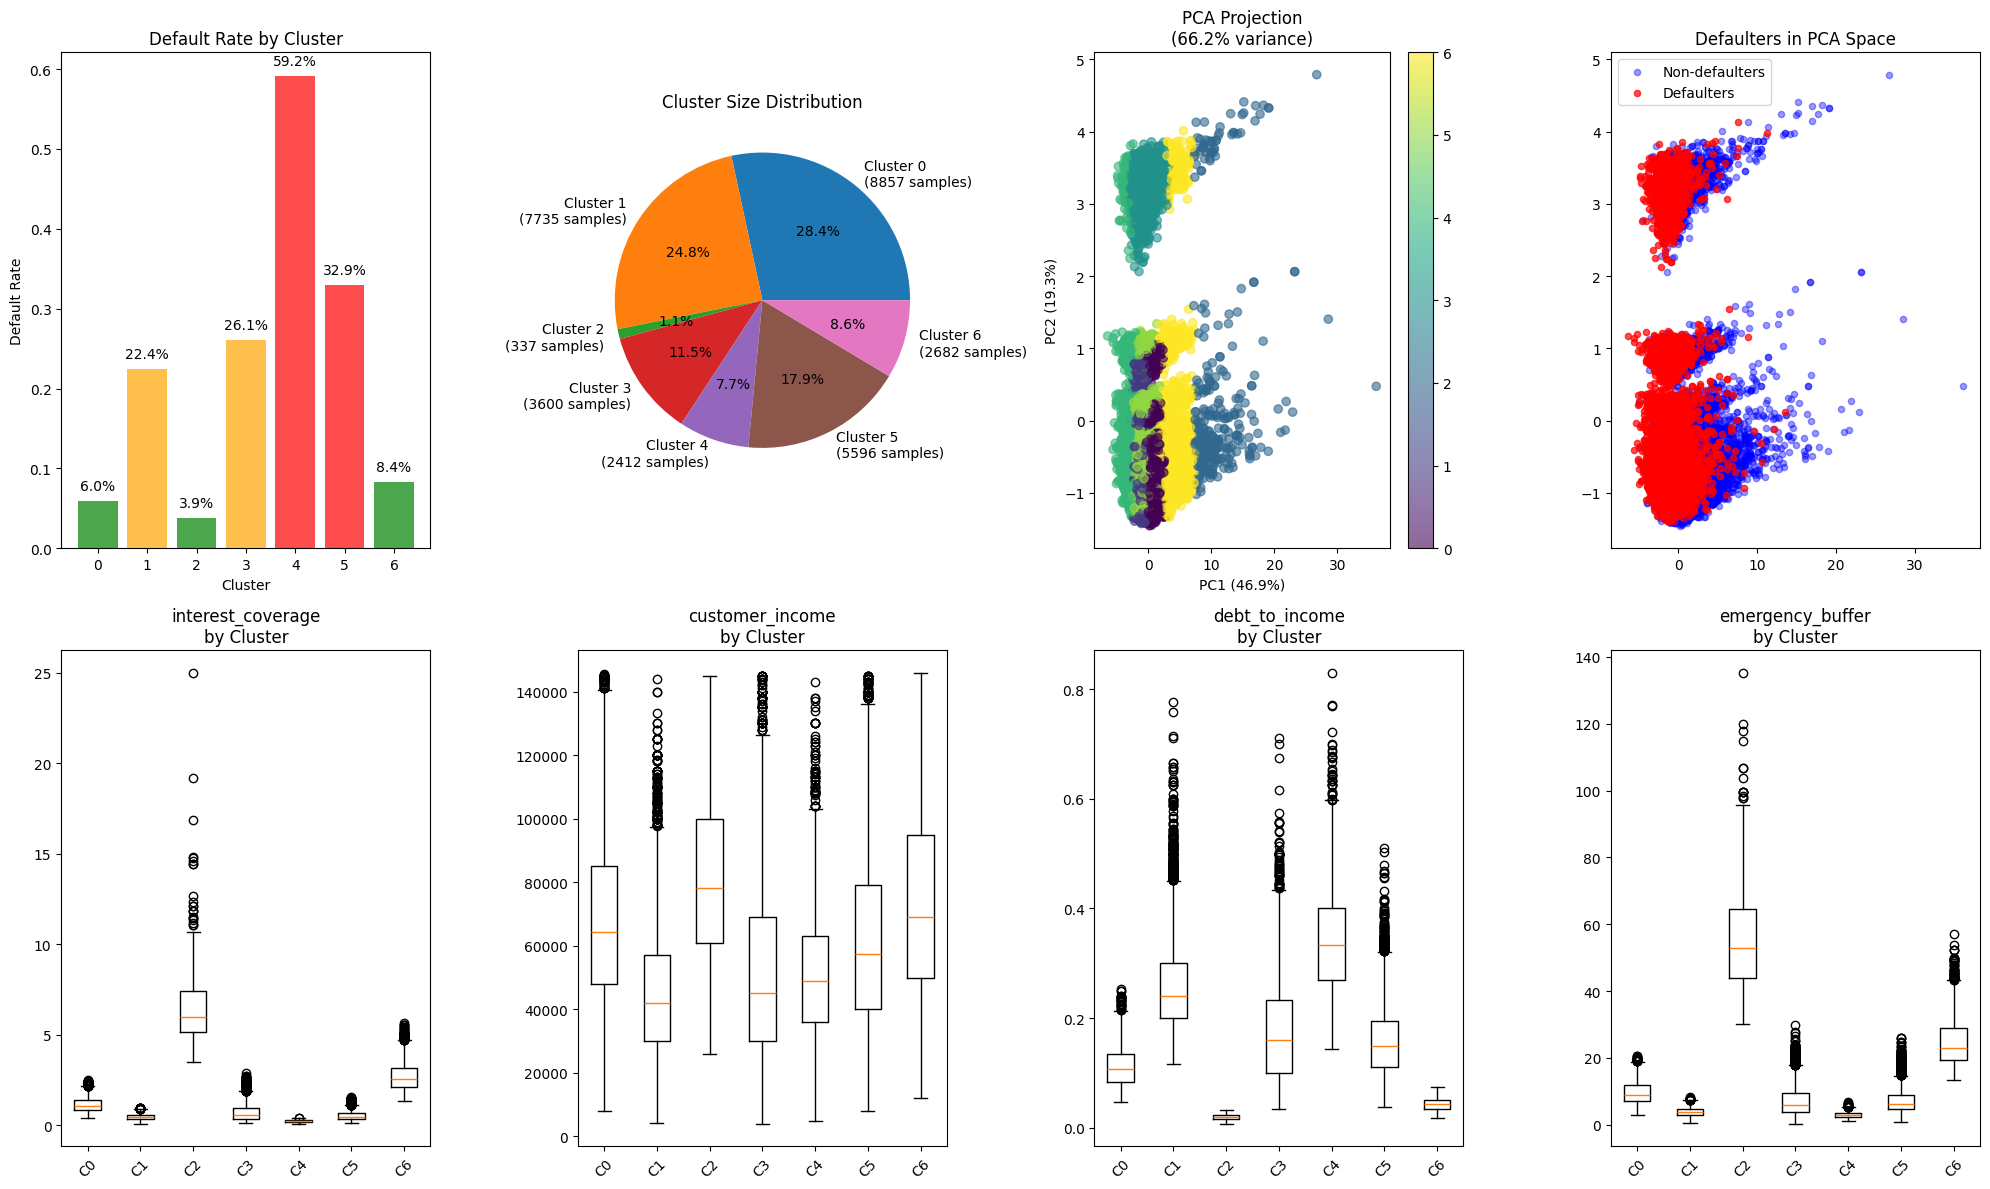

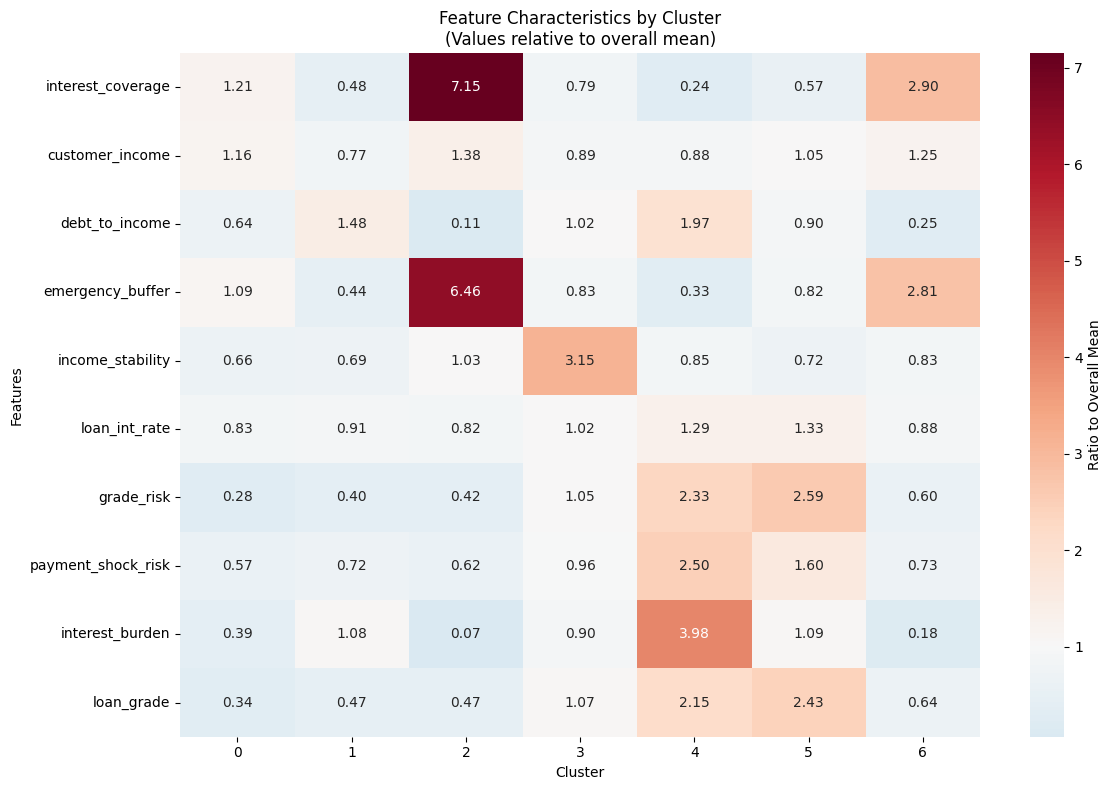


✅ Analysis Complete!
Best clustering method: {'model': KMeans(max_iter=500, n_clusters=7, n_init=20, random_state=42), 'labels': array([0, 4, 4, ..., 5, 1, 1], shape=(37064,), dtype=int32), 'silhouette': np.float64(0.23233712230059944), 'default_separation': np.float64(0.21662297011076107), 'n_clusters': 7}


In [293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
import warnings
warnings.filterwarnings('ignore')

class DefaultPatternAnalyzer:
    """
    Advanced clustering system specifically designed to uncover default patterns
    in imbalanced loan datasets
    """
    
    def __init__(self, target_col='Current_loan_status', random_state=42):
        self.target_col = target_col
        self.random_state = random_state
        self.scaler = None
        self.selected_features = None
        self.best_model = None
        self.results = {}

    def _find_optimal_features(self, df_clean, all_features, max_features=None):
        """Find optimal number of features using clustering quality metrics"""
        
        if max_features is None:
            max_features = min(len(all_features), len(df_clean) // 10, 20)
        
        print(f"Testing feature counts from 3 to {max_features}")
        print(f"Available features: {len(all_features)}")
        print(f"Clean samples: {len(df_clean)}")
        
        # Test different feature counts
        feature_counts = range(3, max_features + 1)
        scores = {}
        
        for n_feat in feature_counts:
            try:
                # Select features using mutual info
                mi_scores = mutual_info_classif(
                    df_clean[all_features], 
                    df_clean[self.target_col], 
                    random_state=self.random_state
                )
                
                # Get top features
                feature_scores = list(zip(all_features, mi_scores))
                feature_scores.sort(key=lambda x: x[1], reverse=True)
                features = [f[0] for f in feature_scores[:n_feat] if f[1] > 0]
                
                if len(features) < 3:
                    print(f"  n={n_feat}: Too few informative features ({len(features)})")
                    continue
                    
                # Quick clustering test
                X = df_clean[features].values
                
                # Check for variance
                if np.any(np.std(X, axis=0) == 0):
                    print(f"  n={n_feat}: Zero variance features detected")
                    continue
                    
                scaler = RobustScaler()
                X_scaled = scaler.fit_transform(X)
                
                # Test with 3 clusters
                kmeans = KMeans(n_clusters=3, n_init=10, random_state=self.random_state, max_iter=300)
                labels = kmeans.fit_predict(X_scaled)
                
                # Check if we got multiple clusters
                if len(np.unique(labels)) < 2:
                    print(f"  n={n_feat}: Only got {len(np.unique(labels))} cluster(s)")
                    continue
                
                # Calculate quality metrics
                silhouette = silhouette_score(X_scaled, labels)
                default_separation = self._calculate_default_separation(labels, df_clean[self.target_col].values)
                
                # Combined score (prioritize default separation)
                combined_score = default_separation * 0.8 + silhouette * 0.2
                scores[n_feat] = combined_score
                
                print(f"  n={n_feat}: Score={combined_score:.3f} (sep={default_separation:.3f}, sil={silhouette:.3f})")
                
            except Exception as e:
                print(f"  n={n_feat}: Error - {str(e)}")
                continue
        
        if not scores:
            print("No valid feature counts found, using fallback of 8")
            return 8
        
        # Find optimal with preference for smaller n if similar performance
        max_score = max(scores.values())
        optimal_n = None
        
        for n_feat in sorted(scores.keys()):
            if scores[n_feat] >= max_score * 0.95:  # Within 5% of best
                optimal_n = n_feat
                break
        
        if optimal_n is None:
            optimal_n = max(scores, key=scores.get)
        
        print(f"Selected optimal features: {optimal_n} (score: {scores[optimal_n]:.3f})")
        return optimal_n

    def prepare_features(self, df, feature_selection_method='mutual_info', n_features=10):
        """
        Advanced feature selection focused on default prediction
        """
        print("=== FEATURE PREPARATION ===")
        
        # Get numeric features
        numeric_features = df.select_dtypes(include=[np.number]).columns.tolist()
        if self.target_col in numeric_features:
            numeric_features.remove(self.target_col)
        
        print(f"Available numeric features: {len(numeric_features)}")
        
        # Create additional risk features if base features exist
        risk_features = self._create_risk_features(df)
        all_features = list(set(numeric_features + risk_features))
        
        # Clean data
        df_clean = df[all_features + [self.target_col]].dropna()
        print(f"Clean samples: {len(df_clean)} (dropped {len(df) - len(df_clean)} rows)")
        
        if len(df_clean) < 100:
            print("Warning: Very few clean samples available!")
            
        # Analyze target distribution
        target_dist = df_clean[self.target_col].value_counts()
        default_rate = target_dist.get(1, 0) / len(df_clean) if len(df_clean) > 0 else 0
        print(f"Default rate: {default_rate:.1%}")
        print(f"Target distribution:\n{target_dist}")
        
        # Feature selection based on method
        if feature_selection_method == 'mutual_info':
            selected_features = self._select_by_mutual_info(df_clean, all_features, n_features)
        elif feature_selection_method == 'f_score':
            selected_features = self._select_by_f_score(df_clean, all_features, n_features)
        else:
            selected_features = self._select_by_default_correlation(df_clean, all_features, n_features)
        
        self.selected_features = selected_features
        print(f"Selected features: {selected_features}")
        
        return df_clean
    
    def _create_risk_features(self, df):
        """Dynamically create risk features using statistical methods"""
        risk_features = []
        
        # Get all numeric columns
        numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
        if self.target_col in numeric_cols:
            numeric_cols.remove(self.target_col)
        
        if len(numeric_cols) == 0 or self.target_col not in df.columns:
            return risk_features
        
        # Clean data for analysis
        df_clean = df[numeric_cols + [self.target_col]].dropna()
        if len(df_clean) < 50:
            return risk_features
        
        # Calculate mutual information for all features
        try:
            mi_scores = mutual_info_classif(df_clean[numeric_cols], df_clean[self.target_col], random_state=self.random_state)
            feature_importance = dict(zip(numeric_cols, mi_scores))
        except:
            return risk_features
        
        # Create risk features for top predictive features
        top_features = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)[:6]
        
        for feature, importance in top_features:
            if importance > 0.001:  # Only create if feature has predictive power
                # Create high-risk threshold features
                q75 = df[feature].quantile(0.75)
                q90 = df[feature].quantile(0.90)
                
                # Binary high-risk indicator
                high_risk_col = f'high_{feature}'
                df[high_risk_col] = (df[feature] > q75).astype(int)
                risk_features.append(high_risk_col)
                
                # Extreme risk indicator for very predictive features
                if importance > 0.01:
                    extreme_risk_col = f'extreme_{feature}'
                    df[extreme_risk_col] = (df[feature] > q90).astype(int)
                    risk_features.append(extreme_risk_col)
        
        # Create interaction features between top 2 most predictive features
        if len(top_features) >= 2:
            feat1, feat2 = top_features[0][0], top_features[1][0]
            interaction_col = f'{feat1}_x_{feat2}_risk'
            df[interaction_col] = ((df[feat1] > df[feat1].quantile(0.75)) & 
                                (df[feat2] > df[feat2].quantile(0.75))).astype(int)
            risk_features.append(interaction_col)
        
        # Create composite risk score from top features
        if len(top_features) >= 3:
            risk_components = []
            for feature, importance in top_features[:5]:
                # Normalize and weight by importance
                normalized = (df[feature] - df[feature].min()) / (df[feature].max() - df[feature].min())
                weighted = normalized * importance
                risk_components.append(weighted)
            
            df['composite_risk_score'] = sum(risk_components)
            risk_features.append('composite_risk_score')
        
        print(f"Created {len(risk_features)} dynamic risk features from top predictors")
        print(f"Risk features: {risk_features}")
        return risk_features

    def _select_by_mutual_info(self, df, features, n_features):
        """Select features using mutual information"""
        mi_scores = mutual_info_classif(df[features], df[self.target_col], random_state=self.random_state)
        mi_df = pd.DataFrame({'feature': features, 'mi_score': mi_scores})
        mi_df = mi_df.sort_values('mi_score', ascending=False)
        
        # Plot feature importance
        plt.figure(figsize=(12, 6))
        top_features = mi_df[mi_df['mi_score'] > 0]
        plt.barh(top_features['feature'], top_features['mi_score'])
        plt.title('Feature Importance (Mutual Information)')
        plt.xlabel('Mutual Information Score')
        plt.tight_layout()
        plt.show()
        
        return mi_df.head(n_features)['feature'].tolist()
    
    def _select_by_f_score(self, df, features, n_features):
        """Select features using F-score"""
        selector = SelectKBest(score_func=f_classif, k=min(n_features, len(features)))
        selector.fit(df[features], df[self.target_col])
        selected_mask = selector.get_support()
        return [features[i] for i, selected in enumerate(selected_mask) if selected]
    
    def _select_by_default_correlation(self, df, features, n_features):
        """Select features by correlation with default"""
        correlations = df[features + [self.target_col]].corr()[self.target_col].abs().sort_values(ascending=False)
        return correlations.head(n_features + 1).index.tolist()[1:]  # Exclude target itself
    
    def analyze_defaulter_patterns(self, df, sampling_strategy='none'):
        """
        Specialized clustering to identify default patterns
        """
        print("\n=== DEFAULTER PATTERN ANALYSIS ===")
        
        # Prepare data
        optimal_n = self._find_optimal_features(df, df.columns, max_features=None)
        print(f"Optimal number of features for clustering: {optimal_n}")
        df_clean = self.prepare_features(df, n_features=optimal_n)
        X = df_clean[self.selected_features].values
        y = df_clean[self.target_col].values
        
        # Handle class imbalance if requested
        if sampling_strategy != 'none':
            X, y = self._handle_imbalance(X, y, sampling_strategy)
            print(f"After resampling: {len(X)} samples, {np.mean(y):.1%} default rate")
        
        # Scale features
        self.scaler = RobustScaler()  # Better for outliers
        X_scaled = self.scaler.fit_transform(X)
        
        # Try multiple clustering algorithms
        clustering_results = {}
        
        # 1. KMeans with different cluster numbers
        print("\nTesting KMeans clustering...")
        kmeans_results = self._test_kmeans_clustering(X_scaled, y)
        clustering_results['kmeans'] = kmeans_results
        
        # 2. Gaussian Mixture Models
        print("\nTesting Gaussian Mixture Models...")
        gmm_results = self._test_gmm_clustering(X_scaled, y)
        clustering_results['gmm'] = gmm_results
        
        # 3. DBSCAN for outlier detection
        print("\nTesting DBSCAN clustering...")
        dbscan_results = self._test_dbscan_clustering(X_scaled, y)
        clustering_results['dbscan'] = dbscan_results
        
        # 4. Hierarchical clustering
        print("\nTesting Hierarchical clustering...")
        hierarchical_results = self._test_hierarchical_clustering(X_scaled, y)
        clustering_results['hierarchical'] = hierarchical_results
        
        # Select best model
        self.best_model = self._select_best_model(clustering_results)
        self.results = clustering_results
        
        return clustering_results
    
    def _handle_imbalance(self, X, y, strategy):
        """Handle class imbalance"""
        if strategy == 'oversample':
            # smote = BorderlineSMOTE(random_state=42, sampling_strategy='minority', k_neighbors=3, m_neighbors=5, kind='borderline-1')
            smote = ADASYN(sampling_strategy=0.5, n_neighbors=5)
            # smote = SMOTE(random_state=self.random_state)
            X_resampled, y_resampled = smote.fit_resample(X, y)
        elif strategy == 'undersample':
            undersampler = RandomUnderSampler(random_state=self.random_state)
            X_resampled, y_resampled = undersampler.fit_resample(X, y)
        else:
            return X, y
        
        return X_resampled, y_resampled
    
    def _test_kmeans_clustering(self, X, y):
        """Test KMeans with different numbers of clusters"""
        results = {}
        
        for n_clusters in range(2, min(8, len(X)//10)):
            try:
                kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=self.random_state, max_iter=500)
                labels = kmeans.fit_predict(X)
                
                # Evaluate clustering quality
                silhouette = silhouette_score(X, labels)
                default_separation = self._calculate_default_separation(labels, y)
                
                results[n_clusters] = {
                    'model': kmeans,
                    'labels': labels,
                    'silhouette': silhouette,
                    'default_separation': default_separation,
                    'n_clusters': len(np.unique(labels))
                }
                
                print(f"  K={n_clusters}: Silhouette={silhouette:.3f}, Default Separation={default_separation:.3f}")
                
            except Exception as e:
                print(f"  K={n_clusters}: Failed - {e}")
                
        return results
    
    def _test_gmm_clustering(self, X, y):
        """Test Gaussian Mixture Models"""
        results = {}
        
        for n_components in range(2, min(6, len(X)//20)):
            try:
                gmm = GaussianMixture(n_components=n_components, random_state=self.random_state)
                labels = gmm.fit_predict(X)
                
                silhouette = silhouette_score(X, labels)
                default_separation = self._calculate_default_separation(labels, y)
                
                results[n_components] = {
                    'model': gmm,
                    'labels': labels,
                    'silhouette': silhouette,
                    'default_separation': default_separation,
                    'n_clusters': len(np.unique(labels))
                }
                
                print(f"  Components={n_components}: Silhouette={silhouette:.3f}, Default Separation={default_separation:.3f}")
                
            except Exception as e:
                print(f"  Components={n_components}: Failed - {e}")
                
        return results
    
    def _test_dbscan_clustering(self, X, y):
        """Test DBSCAN for outlier detection"""
        results = {}
        
        # Test different eps values
        distances = []
        for i in range(min(1000, len(X))):
            distances.extend(np.sort(np.linalg.norm(X - X[i], axis=1))[1:6])  # 5 nearest neighbors
        
        eps_candidates = [np.percentile(distances, p) for p in [25, 50, 75, 90]]
        
        for eps in eps_candidates:
            try:
                dbscan = DBSCAN(eps=eps, min_samples=max(5, len(X)//100))
                labels = dbscan.fit_predict(X)
                
                # Skip if too many or too few clusters
                n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
                if n_clusters < 2 or n_clusters > 10:
                    continue
                
                # Only calculate silhouette if not too many outliers
                outlier_ratio = np.sum(labels == -1) / len(labels)
                if outlier_ratio < 0.5:
                    silhouette = silhouette_score(X[labels != -1], labels[labels != -1]) if len(set(labels[labels != -1])) > 1 else 0
                    default_separation = self._calculate_default_separation(labels, y)
                    
                    results[eps] = {
                        'model': dbscan,
                        'labels': labels,
                        'silhouette': silhouette,
                        'default_separation': default_separation,
                        'n_clusters': n_clusters,
                        'outlier_ratio': outlier_ratio
                    }
                    
                    print(f"  eps={eps:.3f}: Clusters={n_clusters}, Outliers={outlier_ratio:.1%}, Default Sep={default_separation:.3f}")
                
            except Exception as e:
                print(f"  eps={eps:.3f}: Failed - {e}")
                
        return results
    
    def _test_hierarchical_clustering(self, X, y):
        """Test Hierarchical clustering"""
        results = {}
        
        if len(X) > 2000:  # Skip if too large
            print("  Skipping hierarchical (too many samples)")
            return results
        
        for n_clusters in range(2, min(6, len(X)//20)):
            try:
                hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
                labels = hierarchical.fit_predict(X)
                
                silhouette = silhouette_score(X, labels)
                default_separation = self._calculate_default_separation(labels, y)
                
                results[n_clusters] = {
                    'model': hierarchical,
                    'labels': labels,
                    'silhouette': silhouette,
                    'default_separation': default_separation,
                    'n_clusters': n_clusters
                }
                
                print(f"  Clusters={n_clusters}: Silhouette={silhouette:.3f}, Default Separation={default_separation:.3f}")
                
            except Exception as e:
                print(f"  Clusters={n_clusters}: Failed - {e}")
                
        return results
    
    def _calculate_default_separation(self, labels, y):
        """
        Calculate how well clustering separates defaulters from non-defaulters
        Higher score means better separation
        """
        if len(np.unique(labels)) < 2:
            return 0
        
        cluster_default_rates = []
        for cluster in np.unique(labels):
            if cluster == -1:  # Skip outliers in DBSCAN
                continue
            mask = labels == cluster
            if np.sum(mask) > 0:
                default_rate = np.mean(y[mask])
                cluster_default_rates.append(default_rate)
        
        if len(cluster_default_rates) < 2:
            return 0
        
        # Return standard deviation of default rates (higher = better separation)
        return np.std(cluster_default_rates)
    
    def _select_best_model(self, clustering_results):
        """Select the best clustering model based on default separation"""
        best_score = 0
        best_model = None
        best_algorithm = None
        best_params = None
        
        for algorithm, results in clustering_results.items():
            for params, result in results.items():
                # Combine default separation and silhouette score
                score = result['default_separation'] * 0.7 + result['silhouette'] * 0.3
                
                if score > best_score:
                    best_score = score
                    best_model = result
                    best_algorithm = algorithm
                    best_params = params
        
        if best_model:
            print(f"\nBest model: {best_algorithm} (params: {best_params})")
            print(f"Score: {best_score:.3f} (Default Sep: {best_model['default_separation']:.3f}, Silhouette: {best_model['silhouette']:.3f})")
        
        return best_model
    
    def generate_insights(self, df):
        """Generate detailed insights about default patterns"""
        if not self.best_model:
            print("No clustering model available. Run analyze_defaulter_patterns() first.")
            return None
        
        print("\n" + "="*60)
        print("DEFAULT PATTERN INSIGHTS")
        print("="*60)
        
        # Prepare data
        df_clean = df[self.selected_features + [self.target_col]].dropna()
        labels = self.best_model['labels']
        
        # Handle case where labels might be from resampled data
        if len(labels) != len(df_clean):
            print("Warning: Label length mismatch, using original data")
            X_scaled = self.scaler.transform(df_clean[self.selected_features])
            if hasattr(self.best_model['model'], 'predict'):
                labels = self.best_model['model'].predict(X_scaled)
            else:
                print("Cannot generate labels for this data")
                return None
        
        df_analysis = df_clean.copy()
        df_analysis['cluster'] = labels
        
        # Cluster analysis
        insights = {}
        
        for cluster in sorted(df_analysis['cluster'].unique()):
            if cluster == -1:  # Skip outliers
                continue
                
            cluster_data = df_analysis[df_analysis['cluster'] == cluster]
            cluster_size = len(cluster_data)
            default_rate = cluster_data[self.target_col].mean()
            
            print(f"\nCLUSTER {cluster} - {'HIGH RISK' if default_rate > 0.3 else 'MEDIUM RISK' if default_rate > 0.15 else 'LOW RISK'}")
            print(f"Size: {cluster_size} ({cluster_size/len(df_analysis)*100:.1f}%)")
            print(f"Default Rate: {default_rate:.1%}")
            
            # Feature characteristics
            feature_stats = {}
            for feature in self.selected_features:
                if feature in cluster_data.columns:
                    mean_val = cluster_data[feature].mean()
                    overall_mean = df_analysis[feature].mean()
                    ratio = mean_val / overall_mean if overall_mean != 0 else 1
                    feature_stats[feature] = {
                        'cluster_mean': mean_val,
                        'overall_mean': overall_mean,
                        'ratio': ratio
                    }
                    
                    if abs(ratio - 1) > 0.2:  # Significant difference
                        direction = "higher" if ratio > 1 else "lower"
                        print(f"  {feature}: {mean_val:.3f} ({ratio:.1f}x {direction} than average)")
            
            insights[cluster] = {
                'size': cluster_size,
                'size_pct': cluster_size/len(df_analysis)*100,
                'default_rate': default_rate,
                'risk_level': 'HIGH' if default_rate > 0.3 else 'MEDIUM' if default_rate > 0.15 else 'LOW',
                'features': feature_stats
            }
        
        # Visualization
        self._visualize_clusters(df_analysis)
        
        return insights
    
    def _visualize_clusters(self, df_analysis):
        """Create comprehensive visualizations"""
        labels = df_analysis['cluster'].values
        unique_clusters = sorted([c for c in df_analysis['cluster'].unique() if c != -1])
        
        # Set up the plot
        fig = plt.figure(figsize=(20, 12))
        
        # 1. Cluster default rates
        ax1 = plt.subplot(2, 4, 1)
        default_rates = df_analysis.groupby('cluster')[self.target_col].mean()
        bars = ax1.bar(default_rates.index, default_rates.values, 
                      color=['red' if rate > 0.3 else 'orange' if rate > 0.15 else 'green' 
                            for rate in default_rates.values], alpha=0.7)
        ax1.set_title('Default Rate by Cluster')
        ax1.set_ylabel('Default Rate')
        ax1.set_xlabel('Cluster')
        
        # Add value labels on bars
        for bar, rate in zip(bars, default_rates.values):
            ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                    f'{rate:.1%}', ha='center', va='bottom')
        
        # 2. Cluster sizes
        ax2 = plt.subplot(2, 4, 2)
        cluster_sizes = df_analysis['cluster'].value_counts().sort_index()
        ax2.pie(cluster_sizes.values, labels=[f'Cluster {c}\n({s} samples)' 
                                            for c, s in zip(cluster_sizes.index, cluster_sizes.values)], 
               autopct='%1.1f%%')
        ax2.set_title('Cluster Size Distribution')
        
        # 3. PCA visualization
        ax3 = plt.subplot(2, 4, 3)
        X_scaled = self.scaler.transform(df_analysis[self.selected_features])
        pca = PCA(n_components=2, random_state=self.random_state)
        X_pca = pca.fit_transform(X_scaled)
        
        scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis', alpha=0.6)
        ax3.set_title(f'PCA Projection\n({pca.explained_variance_ratio_.sum():.1%} variance)')
        ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%})')
        ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%})')
        plt.colorbar(scatter, ax=ax3)
        
        # 4. Default vs Non-default in PCA space
        ax4 = plt.subplot(2, 4, 4)
        defaulters = df_analysis[self.target_col] == 1
        ax4.scatter(X_pca[~defaulters, 0], X_pca[~defaulters, 1], 
                   c='blue', alpha=0.4, label='Non-defaulters', s=20)
        ax4.scatter(X_pca[defaulters, 0], X_pca[defaulters, 1], 
                   c='red', alpha=0.7, label='Defaulters', s=20)
        ax4.set_title('Defaulters in PCA Space')
        ax4.legend()
        
        # 5-8. Feature distributions by cluster (top 4 features)
        top_features = self.selected_features[:4]
        for i, feature in enumerate(top_features):
            ax = plt.subplot(2, 4, 5 + i)
            
            # Box plot by cluster
            cluster_data = []
            cluster_labels = []
            for cluster in unique_clusters:
                cluster_feature_data = df_analysis[df_analysis['cluster'] == cluster][feature]
                if len(cluster_feature_data) > 0:
                    cluster_data.append(cluster_feature_data)
                    cluster_labels.append(f'C{cluster}')
            
            if cluster_data:
                ax.boxplot(cluster_data, labels=cluster_labels)
                ax.set_title(f'{feature}\nby Cluster')
                ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Additional heatmap for feature correlation with clusters
        self._plot_feature_heatmap(df_analysis)
    
    def _plot_feature_heatmap(self, df_analysis):
        """Plot heatmap of feature means by cluster"""
        plt.figure(figsize=(12, 8))
        
        # Calculate feature means by cluster
        feature_means = df_analysis.groupby('cluster')[self.selected_features].mean()
        
        # Normalize by overall mean to show relative differences
        overall_means = df_analysis[self.selected_features].mean()
        normalized_means = feature_means.div(overall_means, axis=1)
        
        # Create heatmap
        sns.heatmap(normalized_means.T, annot=True, cmap='RdBu_r', center=1, 
                   fmt='.2f', cbar_kws={'label': 'Ratio to Overall Mean'})
        plt.title('Feature Characteristics by Cluster\n(Values relative to overall mean)')
        plt.xlabel('Cluster')
        plt.ylabel('Features')
        plt.tight_layout()
        plt.show()

# Main function to run the analysis
def discover_default_patterns(df, target_col='Current_loan_status', 
                            sampling_strategy='none', feature_selection='mutual_info'):
    """
    Main function to discover default patterns in loan data
    
    Parameters:
    - df: DataFrame with loan data
    - target_col: name of the target column (1 for default, 0 for non-default)
    - sampling_strategy: 'none', 'oversample', or 'undersample'
    - feature_selection: 'mutual_info', 'f_score', or 'correlation'
    """
    
    print("🔍 STARTING DEFAULT PATTERN DISCOVERY")
    print("="*50)
    
    # Initialize analyzer
    analyzer = DefaultPatternAnalyzer(target_col=target_col)
    
    # Run clustering analysis
    clustering_results = analyzer.analyze_defaulter_patterns(df, sampling_strategy)
    
    if not clustering_results or not analyzer.best_model:
        print("❌ Clustering analysis failed!")
        return None, None
    
    # Generate insights
    insights = analyzer.generate_insights(df)
    
    print("\n✅ Analysis Complete!")
    print(f"Best clustering method: {analyzer.best_model}")
    
    return analyzer, insights

# Example usage:
analyzer, insights = discover_default_patterns(
    processed_data['original_data'].drop(columns=['customer_id'], axis=1), 
    target_col='Current_loan_status',
    sampling_strategy='oversample',  # or 'oversample' or 'undersample' or 'none'
    feature_selection='mutual_info' # or 'f_score' or 'correlation' or 'mutual_info'
)